In [1]:
from tf_chpvk_pv.dataset import *
import pandas as pd

df = create_dataset()

train_df, test_df = train_test_split_()

2025-03-06 14:01:22.827 | INFO     | tf_chpvk_pv.config:<module>:11 - PROJ_ROOT path is: /home/nomad-lanasc/Documents/Diego Garzon/TF-ChPVK-PV


2025-03-06 14:01:23.392 | INFO     | tf_chpvk_pv.dataset:create_dataset:38 - Processing dataset...
2025-03-06 14:01:24.530 | SUCCESS  | tf_chpvk_pv.dataset:create_dataset:163 - Processing dataset complete.
2025-03-06 14:01:24.719 | INFO     | tf_chpvk_pv.dataset:train_test_split_:177 - Creating train and test dataset...
2025-03-06 14:01:24.734 | SUCCESS  | tf_chpvk_pv.dataset:train_test_split_:211 - Creating train and test dataset complete.


In [2]:
#count the number of material in each class in the training/test sets
dict_ch = {133.15:'F',
           180.61:'Cl',
           198.14:'Se',
           195.56:'Br',
           184.40:'S',
           219.49:'I'
          }

train_df['X'] = train_df.replace({'rX':dict_ch})['rX']
test_df['X'] = test_df.replace({'rX':dict_ch})['rX']

train_vc = pd.DataFrame(train_df[['X', 'exp_label']].groupby('X')['exp_label'].value_counts())
test_vc = pd.DataFrame(test_df[['X', 'exp_label']].groupby('X')['exp_label'].value_counts())

print('In the training set, %s compositions are unstable and %s are stable.' % (train_df['exp_label'].value_counts().values[0], train_df['exp_label'].value_counts().values[1]))
print('The distribution in the training set by anions is the following')
display(train_vc)

print('In the test set, %s compositions are unstable and %s are stable.' % (test_df['exp_label'].value_counts().values[0], test_df['exp_label'].value_counts().values[1]))
print('The distribution in the test set by anions is the following')
display(test_vc)

In the training set, 141 compositions are unstable and 85 are stable.
The distribution in the training set by anions is the following


count
X  exp_label       
Br 0.0           17
   1.0            4
Cl 0.0           43
   1.0           14
F  1.0           40
   0.0           13
I  0.0           29
   1.0            5
S  0.0           26
   1.0           21
Se 0.0           13
   1.0            1

In the test set, 34 compositions are unstable and 23 are stable.
The distribution in the test set by anions is the following


count
X  exp_label       
Br 0.0            5
   1.0            1
Cl 0.0           10
   1.0            4
F  1.0           11
   0.0            2
I  0.0            7
   1.0            2
S  0.0            7
   1.0            5
Se 0.0            3

In [3]:
import glob as gl

files = gl.glob('/home/nomad-lanasc/Documents/Diego Garzon/TF-ChPVK-PV/data/features_space/features/features/*.csv')

Classification tree accuracy (for t) on the train set: 0.637168.
Classification tree accuracy (for t) on the train set (5 fold CV): 0.606280.
Classification tree accuracy (for t) on the test set: 0.596491.
0.868341 < t < 0.909563 indicates stable perovskites.
Classification tree accuracy (for tau) on the train set: 0.884956.
Classification tree accuracy (for tau) on the train set (5 fold CV): 0.880290.
Classification tree accuracy (for tau) on the test set: 0.824561.
tau < 4.180000 indicates stable perovskites.
Classification tree accuracy (for t_jess) on the train set: 0.725664.
Classification tree accuracy (for t_jess) on the train set (5 fold CV): 0.685990.
Classification tree accuracy (for t_jess) on the test set: 0.631579.
0.835219 < t_jess < 1.022730 indicates stable perovskites.
2025-03-06 14:01:25.544 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features:81 - Training tree model with SISSO features...
Identified expression for t_sisso: (((rA_rX_ratio / log_rA_rB_ratio

/home/nomad-lanasc/.pyenv/lib/python3.11/site-packages/sklearn/utils/_array_api.py:745: RuntimeWarning: overflow encountered in cast
  array = numpy.asarray(array, order=order, dtype=dtype)
/home/nomad-lanasc/.pyenv/lib/python3.11/site-packages/sklearn/utils/_array_api.py:745: RuntimeWarning: overflow encountered in cast
  array = numpy.asarray(array, order=order, dtype=dtype)
/home/nomad-lanasc/.pyenv/lib/python3.11/site-packages/sklearn/utils/_array_api.py:745: RuntimeWarning: overflow encountered in cast
  array = numpy.asarray(array, order=order, dtype=dtype)
/home/nomad-lanasc/.pyenv/lib/python3.11/site-packages/sklearn/utils/_array_api.py:745: RuntimeWarning: overflow encountered in cast
  array = numpy.asarray(array, order=order, dtype=dtype)
/home/nomad-lanasc/.pyenv/lib/python3.11/site-packages/sklearn/utils/_array_api.py:745: RuntimeWarning: overflow encountered in cast
  array = numpy.asarray(array, order=order, dtype=dtype)


Error in /home/nomad-lanasc/Documents/Diego Garzon/TF-ChPVK-PV/data/features_space/features/features/features_sisso_261.csv
2025-03-06 14:23:14.722 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features:81 - Training tree model with SISSO features...
Identified expression for t_sisso: ((rB_rX_ratio / log(rB_rX_ratio)) / exp((rA_rX_ratio / log_rA_rB_ratio)))
Classification tree accuracy (for t_sisso_304) on the train set: 0.831858.
Classification tree accuracy (for t_sisso_304) on the train set (5 fold CV): 0.822802.
Classification tree accuracy (for t_sisso_304) on the test set: 0.842105.
t_sisso_304 < -0.149007 indicates stable perovskites.
2025-03-06 14:23:37.443 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features:81 - Training tree model with SISSO features...
Identified expression for t_sisso: (|((|rB_rX_ratio - log_rA_rB_ratio|) - (log_rA_rB_ratio**2)) - (|(rB_rX_ratio + log_rA_rB_ratio) - (log_rA_rB_ratio**2)|)|)
Error in /home/nomad-lanasc/Documents/Diego Ga

/home/nomad-lanasc/Documents/Diego Garzon/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:248: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-06 14:57:20.670 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features:81 - Training tree model with SISSO features...
Identified expression for t_sisso: ((sqrt(rA_rX_ratio) - log_rA_rB_ratio) - (sqrt(rB_rX_ratio) - sqrt(log_rA_rB_ratio)))
Classification tree accuracy (for t_sisso_193) on the train set: 0.840708.
Classification tree accuracy (for t_sisso_193) on the train set (5 fold CV): 0.836039.
Classification tree accuracy (for t_sisso_193) on the test set: 0.842105.
t_sisso_193 < 0.413743 indicates stable perovskites.


/home/nomad-lanasc/Documents/Diego Garzon/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:248: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-06 14:57:43.218 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features:81 - Training tree model with SISSO features...
Identified expression for t_sisso: (((rB_rX_ratio**3) * rA_rX_ratio) - ((|rB_rX_ratio - log_rA_rB_ratio|) - log_rA_rB_ratio))
Classification tree accuracy (for t_sisso_124) on the train set: 0.853982.
Classification tree accuracy (for t_sisso_124) on the train set (5 fold CV): 0.853720.
Classification tree accuracy (for t_sisso_124) on the test set: 0.894737.
t_sisso_124 < 0.543744 indicates stable perovskites.


/home/nomad-lanasc/Documents/Diego Garzon/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:248: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-06 14:58:05.900 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features:81 - Training tree model with SISSO features...
Identified expression for t_sisso: (|(|(|rA_rX_ratio - log_rA_rB_ratio|) - (rB_rX_ratio * log_rA_rB_ratio)|) - (sqrt(rB_rX_ratio) * rA_rX_ratio)|)
Error in /home/nomad-lanasc/Documents/Diego Garzon/TF-ChPVK-PV/data/features_space/features/features/features_sisso_208.csv
2025-03-06 14:58:28.259 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features:81 - Training tree model with SISSO features...
Identified expression for t_sisso: (((rA_rX_ratio - log_rA_rB_ratio) + log(log_rA_rB_ratio)) - log((rA_rX_ratio + log_rA_rB_ratio)))
Classification tree accuracy (for t_sisso_25) on the train set: 0.840708.
Classification tree accuracy (for t_sisso_25) on the train set (5 fold CV): 0.827246.
Classification tree accuracy (for t_sisso_25) on the test set: 0.824561.
t_sisso_25 < -0.644826 indicates stable perovskites.


/home/nomad-lanasc/Documents/Diego Garzon/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:248: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-06 14:58:50.912 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features:81 - Training tree model with SISSO features...
Identified expression for t_sisso: ((exp(rA_rX_ratio) - (rA_rX_ratio - log_rA_rB_ratio)) - (|exp(rB_rX_ratio) - exp(log_rA_rB_ratio)|))
Classification tree accuracy (for t_sisso_136) on the train set: 0.867257.
Classification tree accuracy (for t_sisso_136) on the train set (5 fold CV): 0.866957.
Classification tree accuracy (for t_sisso_136) on the test set: 0.877193.
t_sisso_136 < 1.849680 indicates stable perovskites.


/home/nomad-lanasc/Documents/Diego Garzon/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:248: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-06 14:59:13.281 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features:81 - Training tree model with SISSO features...
Identified expression for t_sisso: (((chi_BX_ratio / rB_rX_ratio) / (log_rA_rB_ratio**2)) / ((rB_rX_ratio**3)**3))
Classification tree accuracy (for t_sisso_311) on the train set: 0.761062.
Classification tree accuracy (for t_sisso_311) on the train set (5 fold CV): 0.756329.
Classification tree accuracy (for t_sisso_311) on the test set: 0.807018.
t_sisso_311 < 4043.921265 indicates stable perovskites.


/home/nomad-lanasc/Documents/Diego Garzon/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:248: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-06 14:59:35.877 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features:81 - Training tree model with SISSO features...
Identified expression for t_sisso: (((chi_BX_ratio / log_rA_rB_ratio) + (log_rA_rB_ratio / rB_rX_ratio)) / (exp(chi_BX_ratio) + (chi_BX_ratio + log_rA_rB_ratio)))
Classification tree accuracy (for t_sisso_87) on the train set: 0.853982.
Classification tree accuracy (for t_sisso_87) on the train set (5 fold CV): 0.849565.
Classification tree accuracy (for t_sisso_87) on the test set: 0.894737.
t_sisso_87 < 0.724561 indicates stable perovskites.


/home/nomad-lanasc/Documents/Diego Garzon/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:248: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-06 14:59:58.241 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features:81 - Training tree model with SISSO features...
Identified expression for t_sisso: (|(|rB_rX_ratio - log_rA_rB_ratio|) - (rB_rX_ratio + log_rA_rB_ratio)|)
Error in /home/nomad-lanasc/Documents/Diego Garzon/TF-ChPVK-PV/data/features_space/features/features/features_sisso_58.csv
2025-03-06 15:00:20.782 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features:81 - Training tree model with SISSO features...
Identified expression for t_sisso: (((rA_rX_ratio * rB_rX_ratio) * (|rA_rX_ratio - chi_BX_ratio|)) + (|(|rB_rX_ratio - log_rA_rB_ratio|) - (rB_rX_ratio + log_rA_rB_ratio)|))
Error in /home/nomad-lanasc/Documents/Diego Garzon/TF-ChPVK-PV/data/features_space/features/features/features_sisso_39.csv
2025-03-06 15:00:42.992 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features:81 - Training tree model with SISSO features...
Identified expression for t_sisso: (((chi_BX_ratio**2)**2) + (sqr

/home/nomad-lanasc/Documents/Diego Garzon/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:248: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-06 15:01:05.485 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features:81 - Training tree model with SISSO features...
Identified expression for t_sisso: ((|(rA_rX_ratio * log_rA_rB_ratio) - exp(log_rA_rB_ratio)|) * (|(|rB_rX_ratio - log_rA_rB_ratio|) - rA_rX_ratio|))
Error in /home/nomad-lanasc/Documents/Diego Garzon/TF-ChPVK-PV/data/features_space/features/features/features_sisso_212.csv
2025-03-06 15:01:27.871 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features:81 - Training tree model with SISSO features...
Identified expression for t_sisso: (((1.0 / rB_rX_ratio) + (1.0 / log_rA_rB_ratio)) + (rA_rX_ratio + log_rA_rB_ratio))
Classification tree accuracy (for t_sisso_115) on the train set: 0.871681.
Classification tree accuracy (for t_sisso_115) on the train set (5 fold CV): 0.862512.
Classification tree accuracy (for t_sisso_115) on the test set: 0.877193.
t_sisso_115 < 5.321800 indicates stable perovskites.


/home/nomad-lanasc/Documents/Diego Garzon/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:248: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-06 15:01:50.478 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features:81 - Training tree model with SISSO features...
Identified expression for t_sisso: ((sqrt(rB_rX_ratio) * (rB_rX_ratio * log_rA_rB_ratio)) * ((chi_BX_ratio**3)**3))
Classification tree accuracy (for t_sisso_288) on the train set: 0.787611.
Classification tree accuracy (for t_sisso_288) on the train set (5 fold CV): 0.787729.
Classification tree accuracy (for t_sisso_288) on the test set: 0.736842.
t_sisso_288 < 1.955000 indicates stable perovskites.


/home/nomad-lanasc/Documents/Diego Garzon/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:248: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-06 15:02:12.878 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features:81 - Training tree model with SISSO features...
Identified expression for t_sisso: ((|(1.0 / rB_rX_ratio) - (1.0 / log_rA_rB_ratio)|) + ((1.0 / rB_rX_ratio) + (1.0 / log_rA_rB_ratio)))
Classification tree accuracy (for t_sisso_49) on the train set: 0.853982.
Classification tree accuracy (for t_sisso_49) on the train set (5 fold CV): 0.853623.
Classification tree accuracy (for t_sisso_49) on the test set: 0.912281.
t_sisso_49 < 4.377569 indicates stable perovskites.


/home/nomad-lanasc/Documents/Diego Garzon/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:248: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-06 15:02:35.479 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features:81 - Training tree model with SISSO features...
Identified expression for t_sisso: (((rA_rX_ratio * rB_rX_ratio) - (rA_rX_ratio - log_rA_rB_ratio)) * (sqrt(rA_rX_ratio) - sqrt(log_rA_rB_ratio)))
Classification tree accuracy (for t_sisso_164) on the train set: 0.840708.
Classification tree accuracy (for t_sisso_164) on the train set (5 fold CV): 0.836039.
Classification tree accuracy (for t_sisso_164) on the test set: 0.789474.
t_sisso_164 < 0.018465 indicates stable perovskites.


/home/nomad-lanasc/Documents/Diego Garzon/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:248: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-06 15:02:57.850 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features:81 - Training tree model with SISSO features...
Identified expression for t_sisso: (((log_rA_rB_ratio / rB_rX_ratio) * log(log_rA_rB_ratio)) / (log(rA_rX_ratio) - (rB_rX_ratio / rA_rX_ratio)))
Classification tree accuracy (for t_sisso_153) on the train set: 0.867257.
Classification tree accuracy (for t_sisso_153) on the train set (5 fold CV): 0.849179.
Classification tree accuracy (for t_sisso_153) on the test set: 0.877193.
t_sisso_153 < 0.884001 indicates stable perovskites.


/home/nomad-lanasc/Documents/Diego Garzon/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:248: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-06 15:03:20.546 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features:81 - Training tree model with SISSO features...
Identified expression for t_sisso: ((sqrt(rA_rX_ratio) + sqrt(log_rA_rB_ratio)) - (sqrt(rB_rX_ratio) + log_rA_rB_ratio))
Classification tree accuracy (for t_sisso_31) on the train set: 0.840708.
Classification tree accuracy (for t_sisso_31) on the train set (5 fold CV): 0.836039.
Classification tree accuracy (for t_sisso_31) on the test set: 0.842105.
t_sisso_31 < 0.413743 indicates stable perovskites.


/home/nomad-lanasc/Documents/Diego Garzon/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:248: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-06 15:03:43.007 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features:81 - Training tree model with SISSO features...
Identified expression for t_sisso: (((chi_BX_ratio / EA_A) * (chi_BX_ratio**2)) * ((chi_BX_ratio**2)**2))
Classification tree accuracy (for t_sisso_270) on the train set: 0.756637.
Classification tree accuracy (for t_sisso_270) on the train set (5 fold CV): 0.734686.
Classification tree accuracy (for t_sisso_270) on the test set: 0.736842.
t_sisso_270 < -7.101659 indicates stable perovskites.


/home/nomad-lanasc/Documents/Diego Garzon/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:248: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-06 15:04:05.788 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features:81 - Training tree model with SISSO features...
Identified expression for t_sisso: (|log((rA_rX_ratio * log_rA_rB_ratio)) - ((|rB_rX_ratio - log_rA_rB_ratio|) / (rA_rX_ratio * rB_rX_ratio))|)
Error in /home/nomad-lanasc/Documents/Diego Garzon/TF-ChPVK-PV/data/features_space/features/features/features_sisso_209.csv
2025-03-06 15:04:28.167 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features:81 - Training tree model with SISSO features...
Identified expression for t_sisso: ((exp(rA_rX_ratio) - (rA_rX_ratio - log_rA_rB_ratio)) - (|exp(rB_rX_ratio) - exp(log_rA_rB_ratio)|))
Classification tree accuracy (for t_sisso_133) on the train set: 0.867257.
Classification tree accuracy (for t_sisso_133) on the train set (5 fold CV): 0.866957.
Classification tree accuracy (for t_sisso_133) on the test set: 0.877193.
t_sisso_133 < 1.849680 indicates stable perovskites.


/home/nomad-lanasc/Documents/Diego Garzon/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:248: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-06 15:04:50.935 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features:81 - Training tree model with SISSO features...
Identified expression for t_sisso: ((rB_rX_ratio / log(rB_rX_ratio)) / exp((rA_rX_ratio / log_rA_rB_ratio)))
Classification tree accuracy (for t_sisso_301) on the train set: 0.831858.
Classification tree accuracy (for t_sisso_301) on the train set (5 fold CV): 0.822802.
Classification tree accuracy (for t_sisso_301) on the test set: 0.842105.
t_sisso_301 < -0.149007 indicates stable perovskites.


/home/nomad-lanasc/Documents/Diego Garzon/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:248: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-06 15:05:13.355 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features:81 - Training tree model with SISSO features...
Identified expression for t_sisso: ((sqrt(rB_rX_ratio) + chi_BX_ratio) + (exp(chi_BX_ratio) + sqrt(log_rA_rB_ratio)))
Classification tree accuracy (for t_sisso_105) on the train set: 0.787611.
Classification tree accuracy (for t_sisso_105) on the train set (5 fold CV): 0.787729.
Classification tree accuracy (for t_sisso_105) on the test set: 0.754386.
t_sisso_105 < 6.203067 indicates stable perovskites.


/home/nomad-lanasc/Documents/Diego Garzon/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:248: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-06 15:05:36.028 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features:81 - Training tree model with SISSO features...
Identified expression for t_sisso: (|(|(rA_rX_ratio - rB_rX_ratio) - rB_rX_ratio|) - (|(|rB_rX_ratio - log_rA_rB_ratio|) - rA_rX_ratio|)|)
Error in /home/nomad-lanasc/Documents/Diego Garzon/TF-ChPVK-PV/data/features_space/features/features/features_sisso_145.csv
2025-03-06 15:05:58.371 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features:81 - Training tree model with SISSO features...
Identified expression for t_sisso: ((sqrt(rA_rX_ratio) - log_rA_rB_ratio) - (sqrt(rB_rX_ratio) - sqrt(log_rA_rB_ratio)))
Classification tree accuracy (for t_sisso_189) on the train set: 0.840708.
Classification tree accuracy (for t_sisso_189) on the train set (5 fold CV): 0.836039.
Classification tree accuracy (for t_sisso_189) on the test set: 0.842105.
t_sisso_189 < 0.413743 indicates stable perovskites.


/home/nomad-lanasc/Documents/Diego Garzon/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:248: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-06 15:06:20.950 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features:81 - Training tree model with SISSO features...
Identified expression for t_sisso: ((|(rA_rX_ratio / chi_BX_ratio) - log_rA_rB_ratio|) + (|(|rB_rX_ratio - log_rA_rB_ratio|) - (chi_BX_ratio + log_rA_rB_ratio)|))
Error in /home/nomad-lanasc/Documents/Diego Garzon/TF-ChPVK-PV/data/features_space/features/features/features_sisso_48.csv
2025-03-06 15:06:43.201 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features:81 - Training tree model with SISSO features...
Identified expression for t_sisso: (((rB_rX_ratio**2) / exp(log_rA_rB_ratio)) / exp((1.0 / log_rA_rB_ratio)))
Classification tree accuracy (for t_sisso_295) on the train set: 0.836283.
Classification tree accuracy (for t_sisso_295) on the train set (5 fold CV): 0.836039.
Classification tree accuracy (for t_sisso_295) on the test set: 0.842105.
t_sisso_295 < 0.022619 indicates stable perovskites.


/home/nomad-lanasc/Documents/Diego Garzon/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:248: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-06 15:07:05.852 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features:81 - Training tree model with SISSO features...
Identified expression for t_sisso: (((chi_BX_ratio**3) - (chi_BX_ratio / log_rA_rB_ratio)) - ((log_rA_rB_ratio / rB_rX_ratio) - log_rA_rB_ratio))
Classification tree accuracy (for t_sisso_151) on the train set: 0.853982.
Classification tree accuracy (for t_sisso_151) on the train set (5 fold CV): 0.853816.
Classification tree accuracy (for t_sisso_151) on the test set: 0.859649.
t_sisso_151 < -1.511530 indicates stable perovskites.


/home/nomad-lanasc/Documents/Diego Garzon/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:248: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-06 15:07:28.246 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features:81 - Training tree model with SISSO features...
Identified expression for t_sisso: ((sqrt(rB_rX_ratio) - (rB_rX_ratio - log_rA_rB_ratio)) - ((rB_rX_ratio - log_rA_rB_ratio) - (1.0 / log_rA_rB_ratio)))
Classification tree accuracy (for t_sisso_186) on the train set: 0.858407.
Classification tree accuracy (for t_sisso_186) on the train set (5 fold CV): 0.853720.
Classification tree accuracy (for t_sisso_186) on the test set: 0.877193.
t_sisso_186 < 2.627082 indicates stable perovskites.


/home/nomad-lanasc/Documents/Diego Garzon/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:248: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-06 15:07:50.918 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features:81 - Training tree model with SISSO features...
Identified expression for t_sisso: (|(|(|rA_rX_ratio - log_rA_rB_ratio|) - (rB_rX_ratio**2)|) - (|(|rB_rX_ratio - log_rA_rB_ratio|) - rA_rX_ratio|)|)
Error in /home/nomad-lanasc/Documents/Diego Garzon/TF-ChPVK-PV/data/features_space/features/features/features_sisso_257.csv
2025-03-06 15:08:13.245 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features:81 - Training tree model with SISSO features...
Identified expression for t_sisso: (|(log(rA_rX_ratio) + (rB_rX_ratio**3)) - ((|rA_rX_ratio - log_rA_rB_ratio|) + (|rB_rX_ratio - log_rA_rB_ratio|))|)
Error in /home/nomad-lanasc/Documents/Diego Garzon/TF-ChPVK-PV/data/features_space/features/features/features_sisso_62.csv
2025-03-06 15:08:35.787 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features:81 - Training tree model with SISSO features...
Identified expression for t_sisso: (((rB_rX_

/home/nomad-lanasc/Documents/Diego Garzon/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:248: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-06 15:08:58.044 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features:81 - Training tree model with SISSO features...
Identified expression for t_sisso: (((rB_rX_ratio**3) / exp(rB_rX_ratio)) / exp((rB_rX_ratio / log_rA_rB_ratio)))
Classification tree accuracy (for t_sisso_296) on the train set: 0.845133.
Classification tree accuracy (for t_sisso_296) on the train set (5 fold CV): 0.836135.
Classification tree accuracy (for t_sisso_296) on the test set: 0.842105.
t_sisso_296 < 0.028827 indicates stable perovskites.


/home/nomad-lanasc/Documents/Diego Garzon/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:248: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-06 15:09:20.669 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features:81 - Training tree model with SISSO features...
Identified expression for t_sisso: ((exp(rB_rX_ratio) * sqrt(log_rA_rB_ratio)) * ((chi_BX_ratio**3)**3))
Classification tree accuracy (for t_sisso_282) on the train set: 0.787611.
Classification tree accuracy (for t_sisso_282) on the train set (5 fold CV): 0.787729.
Classification tree accuracy (for t_sisso_282) on the test set: 0.754386.
t_sisso_282 < 9.194284 indicates stable perovskites.


/home/nomad-lanasc/Documents/Diego Garzon/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:248: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-06 15:09:43.029 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features:81 - Training tree model with SISSO features...
Identified expression for t_sisso: (((rA_rX_ratio * rB_rX_ratio) * (rB_rX_ratio**2)) - ((rA_rX_ratio - log_rA_rB_ratio) * (rB_rX_ratio - log_rA_rB_ratio)))
Classification tree accuracy (for t_sisso_11) on the train set: 0.823009.
Classification tree accuracy (for t_sisso_11) on the train set (5 fold CV): 0.822802.
Classification tree accuracy (for t_sisso_11) on the test set: 0.789474.
t_sisso_11 < 0.117668 indicates stable perovskites.


/home/nomad-lanasc/Documents/Diego Garzon/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:248: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-06 15:10:05.656 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features:81 - Training tree model with SISSO features...
Identified expression for t_sisso: (((rB_rX_ratio / log_rA_rB_ratio) + exp(log_rA_rB_ratio)) / (exp(rA_rX_ratio) + (rB_rX_ratio / rA_rX_ratio)))
Classification tree accuracy (for t_sisso_86) on the train set: 0.862832.
Classification tree accuracy (for t_sisso_86) on the train set (5 fold CV): 0.858164.
Classification tree accuracy (for t_sisso_86) on the test set: 0.842105.
t_sisso_86 < 0.915715 indicates stable perovskites.


/home/nomad-lanasc/Documents/Diego Garzon/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:248: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-06 15:10:28.062 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features:81 - Training tree model with SISSO features...
Identified expression for t_sisso: (exp((1.0 / rB_rX_ratio)) * exp((1.0 / log_rA_rB_ratio)))
Classification tree accuracy (for t_sisso_276) on the train set: 0.814159.
Classification tree accuracy (for t_sisso_276) on the train set (5 fold CV): 0.814106.
Classification tree accuracy (for t_sisso_276) on the test set: 0.771930.
t_sisso_276 < 46.304499 indicates stable perovskites.


/home/nomad-lanasc/Documents/Diego Garzon/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:248: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-06 15:10:50.758 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features:81 - Training tree model with SISSO features...
Identified expression for t_sisso: (((rA_rX_ratio**2) * log_rA_rB_ratio) * (|sqrt(rB_rX_ratio) - (|rB_rX_ratio - log_rA_rB_ratio|)|))
Error in /home/nomad-lanasc/Documents/Diego Garzon/TF-ChPVK-PV/data/features_space/features/features/features_sisso_220.csv
2025-03-06 15:11:13.176 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features:81 - Training tree model with SISSO features...
Identified expression for t_sisso: (((rB_rX_ratio * log_rA_rB_ratio) / (EA_A * rA_rX_ratio)) * ((chi_BX_ratio**3)**3))
Classification tree accuracy (for t_sisso_266) on the train set: 0.778761.
Classification tree accuracy (for t_sisso_266) on the train set (5 fold CV): 0.778841.
Classification tree accuracy (for t_sisso_266) on the test set: 0.736842.
t_sisso_266 < -2.886807 indicates stable perovskites.


/home/nomad-lanasc/Documents/Diego Garzon/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:248: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-06 15:11:35.855 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features:81 - Training tree model with SISSO features...
Identified expression for t_sisso: ((log(rB_rX_ratio)**2) + (log(log_rA_rB_ratio)**2))
Classification tree accuracy (for t_sisso_106) on the train set: 0.827434.
Classification tree accuracy (for t_sisso_106) on the train set (5 fold CV): 0.814010.
Classification tree accuracy (for t_sisso_106) on the test set: 0.771930.
t_sisso_106 < 0.928798 indicates stable perovskites.


/home/nomad-lanasc/Documents/Diego Garzon/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:248: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-06 15:11:58.284 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features:81 - Training tree model with SISSO features...
Identified expression for t_sisso: ((log(rA_rX_ratio) + log_rA_rB_ratio) + ((1.0 / rB_rX_ratio) + (1.0 / log_rA_rB_ratio)))
Classification tree accuracy (for t_sisso_114) on the train set: 0.871681.
Classification tree accuracy (for t_sisso_114) on the train set (5 fold CV): 0.866957.
Classification tree accuracy (for t_sisso_114) on the test set: 0.877193.
t_sisso_114 < 4.297867 indicates stable perovskites.


/home/nomad-lanasc/Documents/Diego Garzon/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:248: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-06 15:12:21.014 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features:81 - Training tree model with SISSO features...
Identified expression for t_sisso: (((rB_rX_ratio - log_rA_rB_ratio) - log_rA_rB_ratio) - ((1.0 / log_rA_rB_ratio) - rB_rX_ratio))
Classification tree accuracy (for t_sisso_185) on the train set: 0.862832.
Classification tree accuracy (for t_sisso_185) on the train set (5 fold CV): 0.853623.
Classification tree accuracy (for t_sisso_185) on the test set: 0.877193.
t_sisso_185 < -1.975124 indicates stable perovskites.


/home/nomad-lanasc/Documents/Diego Garzon/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:248: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-06 15:12:43.393 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features:81 - Training tree model with SISSO features...
Identified expression for t_sisso: (((rA_rX_ratio / log_rA_rB_ratio) - (rA_rX_ratio - log_rA_rB_ratio)) - ((rA_rX_ratio - log_rA_rB_ratio) / sqrt(log_rA_rB_ratio)))
Classification tree accuracy (for t_sisso_183) on the train set: 0.858407.
Classification tree accuracy (for t_sisso_183) on the train set (5 fold CV): 0.849275.
Classification tree accuracy (for t_sisso_183) on the test set: 0.859649.
t_sisso_183 < 0.871024 indicates stable perovskites.


/home/nomad-lanasc/Documents/Diego Garzon/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:248: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-06 15:13:06.071 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features:81 - Training tree model with SISSO features...
Identified expression for t_sisso: ((exp(chi_BX_ratio) - (chi_BX_ratio / log_rA_rB_ratio)) / exp((log_rA_rB_ratio / rB_rX_ratio)))
Classification tree accuracy (for t_sisso_169) on the train set: 0.867257.
Classification tree accuracy (for t_sisso_169) on the train set (5 fold CV): 0.858164.
Classification tree accuracy (for t_sisso_169) on the test set: 0.859649.
t_sisso_169 < 0.228876 indicates stable perovskites.


/home/nomad-lanasc/Documents/Diego Garzon/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:248: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-06 15:13:28.433 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features:81 - Training tree model with SISSO features...
Identified expression for t_sisso: ((log(rA_rX_ratio) + log_rA_rB_ratio) + ((1.0 / rB_rX_ratio) + (1.0 / log_rA_rB_ratio)))
Classification tree accuracy (for t_sisso_103) on the train set: 0.871681.
Classification tree accuracy (for t_sisso_103) on the train set (5 fold CV): 0.866957.
Classification tree accuracy (for t_sisso_103) on the test set: 0.877193.
t_sisso_103 < 4.297867 indicates stable perovskites.


/home/nomad-lanasc/Documents/Diego Garzon/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:248: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-06 15:13:51.091 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features:81 - Training tree model with SISSO features...
Identified expression for t_sisso: ((|(rA_rX_ratio * log_rA_rB_ratio) - exp(log_rA_rB_ratio)|) * (|(|rB_rX_ratio - log_rA_rB_ratio|) - rA_rX_ratio|))
Error in /home/nomad-lanasc/Documents/Diego Garzon/TF-ChPVK-PV/data/features_space/features/features/features_sisso_211.csv
2025-03-06 15:14:13.392 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features:81 - Training tree model with SISSO features...
Identified expression for t_sisso: (|(sqrt(log_rA_rB_ratio) * rA_rX_ratio) - (|rB_rX_ratio - log_rA_rB_ratio|)|)
Error in /home/nomad-lanasc/Documents/Diego Garzon/TF-ChPVK-PV/data/features_space/features/features/features_sisso_224.csv
2025-03-06 15:14:35.920 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features:81 - Training tree model with SISSO features...
Identified expression for t_sisso: (((rA_rX_ratio + log_rA_rB_ratio) + (rB_rX_rat

/home/nomad-lanasc/Documents/Diego Garzon/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:248: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-06 15:14:58.370 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features:81 - Training tree model with SISSO features...
Identified expression for t_sisso: (((rA_rX_ratio / log_rA_rB_ratio) + (log_rA_rB_ratio / rA_rX_ratio)) / ((rB_rX_ratio / chi_BX_ratio) + (rB_rX_ratio + chi_BX_ratio)))
Classification tree accuracy (for t_sisso_65) on the train set: 0.831858.
Classification tree accuracy (for t_sisso_65) on the train set (5 fold CV): 0.822802.
Classification tree accuracy (for t_sisso_65) on the test set: 0.842105.
t_sisso_65 < 1.157727 indicates stable perovskites.


/home/nomad-lanasc/Documents/Diego Garzon/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:248: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-06 15:15:20.995 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features:81 - Training tree model with SISSO features...
Identified expression for t_sisso: (((rB_rX_ratio**2) / sqrt(rA_rX_ratio)) / exp((rB_rX_ratio / log_rA_rB_ratio)))
Classification tree accuracy (for t_sisso_300) on the train set: 0.823009.
Classification tree accuracy (for t_sisso_300) on the train set (5 fold CV): 0.822705.
Classification tree accuracy (for t_sisso_300) on the test set: 0.807018.
t_sisso_300 < 0.107408 indicates stable perovskites.


/home/nomad-lanasc/Documents/Diego Garzon/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:248: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-06 15:15:43.526 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features:81 - Training tree model with SISSO features...
Identified expression for t_sisso: (|(|sqrt(rB_rX_ratio) - log_rA_rB_ratio|) - (|(|rB_rX_ratio - log_rA_rB_ratio|) - rA_rX_ratio|)|)
Error in /home/nomad-lanasc/Documents/Diego Garzon/TF-ChPVK-PV/data/features_space/features/features/features_sisso_253.csv
2025-03-06 15:16:06.095 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features:81 - Training tree model with SISSO features...
Identified expression for t_sisso: (|(|(rA_rX_ratio * log_rA_rB_ratio) - (log_rA_rB_ratio**3)|) - ((rB_rX_ratio**3) * (rB_rX_ratio * log_rA_rB_ratio))|)
Error in /home/nomad-lanasc/Documents/Diego Garzon/TF-ChPVK-PV/data/features_space/features/features/features_sisso_223.csv
2025-03-06 15:16:28.426 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features:81 - Training tree model with SISSO features...
Identified expression for t_sisso: (((rA_rX_ratio - log_rA

/home/nomad-lanasc/Documents/Diego Garzon/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:248: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-06 15:16:50.989 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features:81 - Training tree model with SISSO features...
Identified expression for t_sisso: log((|(|rB_rX_ratio - log_rA_rB_ratio|) - (rB_rX_ratio + log_rA_rB_ratio)|))
Error in /home/nomad-lanasc/Documents/Diego Garzon/TF-ChPVK-PV/data/features_space/features/features/features_sisso_60.csv
2025-03-06 15:17:13.391 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features:81 - Training tree model with SISSO features...
Identified expression for t_sisso: ((|(1.0 / rB_rX_ratio) - (1.0 / log_rA_rB_ratio)|) + ((1.0 / rB_rX_ratio) + (1.0 / log_rA_rB_ratio)))
Classification tree accuracy (for t_sisso_57) on the train set: 0.853982.
Classification tree accuracy (for t_sisso_57) on the train set (5 fold CV): 0.853623.
Classification tree accuracy (for t_sisso_57) on the test set: 0.912281.
t_sisso_57 < 4.377569 indicates stable perovskites.


/home/nomad-lanasc/Documents/Diego Garzon/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:248: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-06 15:17:36.037 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features:81 - Training tree model with SISSO features...
Identified expression for t_sisso: (|(|(rA_rX_ratio - rB_rX_ratio) - rB_rX_ratio|) - (|(|rB_rX_ratio - log_rA_rB_ratio|) - rA_rX_ratio|)|)
Error in /home/nomad-lanasc/Documents/Diego Garzon/TF-ChPVK-PV/data/features_space/features/features/features_sisso_128.csv
2025-03-06 15:17:58.514 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features:81 - Training tree model with SISSO features...
Identified expression for t_sisso: (((rA_rX_ratio * log_rA_rB_ratio) - exp(rB_rX_ratio)) * ((rA_rX_ratio - log_rA_rB_ratio) * (log_rA_rB_ratio**3)))
Classification tree accuracy (for t_sisso_156) on the train set: 0.840708.
Classification tree accuracy (for t_sisso_156) on the train set (5 fold CV): 0.835942.
Classification tree accuracy (for t_sisso_156) on the test set: 0.842105.
t_sisso_156 < -0.053064 indicates stable perovskites.


/home/nomad-lanasc/Documents/Diego Garzon/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:248: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-06 15:18:21.229 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features:81 - Training tree model with SISSO features...
Identified expression for t_sisso: (((EA_A * rA_rX_ratio) * log(rA_rX_ratio)) * ((rA_rX_ratio * log_rA_rB_ratio) / log(rB_rX_ratio)))
Classification tree accuracy (for t_sisso_271) on the train set: 0.800885.
Classification tree accuracy (for t_sisso_271) on the train set (5 fold CV): 0.800870.
Classification tree accuracy (for t_sisso_271) on the test set: 0.736842.
t_sisso_271 < 0.023498 indicates stable perovskites.


/home/nomad-lanasc/Documents/Diego Garzon/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:248: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-06 15:18:43.686 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features:81 - Training tree model with SISSO features...
Identified expression for t_sisso: (|(|(|rB_rX_ratio - log_rA_rB_ratio|) - rA_rX_ratio|) - (|(log_rA_rB_ratio**2) - log_rA_rB_ratio|)|)
Error in /home/nomad-lanasc/Documents/Diego Garzon/TF-ChPVK-PV/data/features_space/features/features/features_sisso_230.csv
2025-03-06 15:19:06.254 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features:81 - Training tree model with SISSO features...
Identified expression for t_sisso: ((sqrt(rA_rX_ratio) - sqrt(rB_rX_ratio)) + (sqrt(log_rA_rB_ratio) - log_rA_rB_ratio))
Classification tree accuracy (for t_sisso_24) on the train set: 0.840708.
Classification tree accuracy (for t_sisso_24) on the train set (5 fold CV): 0.836039.
Classification tree accuracy (for t_sisso_24) on the test set: 0.842105.
t_sisso_24 < 0.413743 indicates stable perovskites.


/home/nomad-lanasc/Documents/Diego Garzon/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:248: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-06 15:19:28.637 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features:81 - Training tree model with SISSO features...
Identified expression for t_sisso: ((|(|rA_rX_ratio - log_rA_rB_ratio|) - (rB_rX_ratio / log_rA_rB_ratio)|) + exp((log_rA_rB_ratio / rA_rX_ratio)))
Error in /home/nomad-lanasc/Documents/Diego Garzon/TF-ChPVK-PV/data/features_space/features/features/features_sisso_43.csv
2025-03-06 15:19:51.231 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features:81 - Training tree model with SISSO features...
Identified expression for t_sisso: (|(|(|rB_rX_ratio - log_rA_rB_ratio|) - rA_rX_ratio|) - (|(log_rA_rB_ratio**2) - log_rA_rB_ratio|)|)
Error in /home/nomad-lanasc/Documents/Diego Garzon/TF-ChPVK-PV/data/features_space/features/features/features_sisso_236.csv
2025-03-06 15:20:13.491 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features:81 - Training tree model with SISSO features...
Identified expression for t_sisso: (((rA_rX_ratio - rB_rX_rat

/home/nomad-lanasc/Documents/Diego Garzon/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:248: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-06 15:20:36.137 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features:81 - Training tree model with SISSO features...
Identified expression for t_sisso: (((rA_rX_ratio - log_rA_rB_ratio) * (log_rA_rB_ratio**2)) * ((log_rA_rB_ratio**3) - (log_rA_rB_ratio**2)))
Classification tree accuracy (for t_sisso_163) on the train set: 0.840708.
Classification tree accuracy (for t_sisso_163) on the train set (5 fold CV): 0.840676.
Classification tree accuracy (for t_sisso_163) on the test set: 0.824561.
t_sisso_163 < -0.010390 indicates stable perovskites.


/home/nomad-lanasc/Documents/Diego Garzon/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:248: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-06 15:20:58.593 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features:81 - Training tree model with SISSO features...
Identified expression for t_sisso: (((rA_rX_ratio / log_rA_rB_ratio) + (log_rA_rB_ratio / rA_rX_ratio)) / ((rB_rX_ratio / chi_BX_ratio) + (rB_rX_ratio + chi_BX_ratio)))
Classification tree accuracy (for t_sisso_94) on the train set: 0.831858.
Classification tree accuracy (for t_sisso_94) on the train set (5 fold CV): 0.822802.
Classification tree accuracy (for t_sisso_94) on the test set: 0.842105.
t_sisso_94 < 1.157727 indicates stable perovskites.


/home/nomad-lanasc/Documents/Diego Garzon/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:248: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-06 15:21:21.248 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features:81 - Training tree model with SISSO features...
Identified expression for t_sisso: (|(|(rA_rX_ratio**2) - (|rB_rX_ratio - log_rA_rB_ratio|)|) - (|sqrt(log_rA_rB_ratio) - rA_rX_ratio|)|)
Error in /home/nomad-lanasc/Documents/Diego Garzon/TF-ChPVK-PV/data/features_space/features/features/features_sisso_256.csv
2025-03-06 15:21:43.519 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features:81 - Training tree model with SISSO features...
Identified expression for t_sisso: (((rA_rX_ratio + rB_rX_ratio) + (rA_rX_ratio + log_rA_rB_ratio)) + ((chi_BX_ratio**3)**3))
Classification tree accuracy (for t_sisso_82) on the train set: 0.783186.
Classification tree accuracy (for t_sisso_82) on the train set (5 fold CV): 0.783382.
Classification tree accuracy (for t_sisso_82) on the test set: 0.754386.
t_sisso_82 < 9.868897 indicates stable perovskites.


/home/nomad-lanasc/Documents/Diego Garzon/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:248: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-06 15:22:06.150 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features:81 - Training tree model with SISSO features...
Identified expression for t_sisso: ((|sqrt(rB_rX_ratio) - (1.0 / log_rA_rB_ratio)|) / (|(|rB_rX_ratio - log_rA_rB_ratio|) - (1.0 / log_rA_rB_ratio)|))
Error in /home/nomad-lanasc/Documents/Diego Garzon/TF-ChPVK-PV/data/features_space/features/features/features_sisso_232.csv
2025-03-06 15:22:28.434 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features:81 - Training tree model with SISSO features...
Identified expression for t_sisso: (((chi_BX_ratio / rA_rX_ratio) - (chi_BX_ratio * log_rA_rB_ratio)) - ((chi_BX_ratio / rB_rX_ratio) * (chi_BX_ratio - log_rA_rB_ratio)))
Classification tree accuracy (for t_sisso_149) on the train set: 0.783186.
Classification tree accuracy (for t_sisso_149) on the train set (5 fold CV): 0.783285.
Classification tree accuracy (for t_sisso_149) on the test set: 0.754386.
t_sisso_149 < -0.961714 indicates stable perov

/home/nomad-lanasc/Documents/Diego Garzon/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:248: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-06 15:22:51.082 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features:81 - Training tree model with SISSO features...
Identified expression for t_sisso: (((rA_rX_ratio + log_rA_rB_ratio) + (rB_rX_ratio + log_rA_rB_ratio)) * log((rB_rX_ratio * log_rA_rB_ratio)))
Classification tree accuracy (for t_sisso_81) on the train set: 0.827434.
Classification tree accuracy (for t_sisso_81) on the train set (5 fold CV): 0.822705.
Classification tree accuracy (for t_sisso_81) on the test set: 0.807018.
t_sisso_81 < -3.214773 indicates stable perovskites.


/home/nomad-lanasc/Documents/Diego Garzon/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:248: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-06 15:23:13.532 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features:81 - Training tree model with SISSO features...
Identified expression for t_sisso: (|((|rB_rX_ratio - log_rA_rB_ratio|) / sqrt(rB_rX_ratio)) - (rA_rX_ratio + log_rA_rB_ratio)|)
Error in /home/nomad-lanasc/Documents/Diego Garzon/TF-ChPVK-PV/data/features_space/features/features/features_sisso_47.csv
2025-03-06 15:23:36.175 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features:81 - Training tree model with SISSO features...
Identified expression for t_sisso: (|(|log(rA_rX_ratio) - (|rB_rX_ratio - log_rA_rB_ratio|)|) - (|sqrt(rA_rX_ratio) - sqrt(chi_BX_ratio)|)|)
Error in /home/nomad-lanasc/Documents/Diego Garzon/TF-ChPVK-PV/data/features_space/features/features/features_sisso_258.csv
2025-03-06 15:23:58.530 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features:81 - Training tree model with SISSO features...
Identified expression for t_sisso: (exp((rB_rX_ratio / rA_rX_ratio)) / (|(|

/home/nomad-lanasc/Documents/Diego Garzon/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:248: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-06 15:24:43.769 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features:81 - Training tree model with SISSO features...
Identified expression for t_sisso: (((rA_rX_ratio / rB_rX_ratio) / log_rA_rB_ratio) / sqrt(rB_rX_ratio))
Classification tree accuracy (for t_sisso_310) on the train set: 0.805310.
Classification tree accuracy (for t_sisso_310) on the train set (5 fold CV): 0.796425.
Classification tree accuracy (for t_sisso_310) on the test set: 0.771930.
t_sisso_310 < 4.470306 indicates stable perovskites.


/home/nomad-lanasc/Documents/Diego Garzon/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:248: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-06 15:25:06.479 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features:81 - Training tree model with SISSO features...
Identified expression for t_sisso: ((log(rA_rX_ratio) - (|rB_rX_ratio - log_rA_rB_ratio|)) + (|(|rA_rX_ratio - log_rA_rB_ratio|) - rB_rX_ratio|))
Error in /home/nomad-lanasc/Documents/Diego Garzon/TF-ChPVK-PV/data/features_space/features/features/features_sisso_7.csv
2025-03-06 15:25:28.861 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features:81 - Training tree model with SISSO features...
Identified expression for t_sisso: ((log(log_rA_rB_ratio) - rA_rX_ratio) - (log(log_rA_rB_ratio)**3))
Classification tree accuracy (for t_sisso_201) on the train set: 0.876106.
Classification tree accuracy (for t_sisso_201) on the train set (5 fold CV): 0.871401.
Classification tree accuracy (for t_sisso_201) on the test set: 0.877193.
t_sisso_201 < -1.192592 indicates stable perovskites.


/home/nomad-lanasc/Documents/Diego Garzon/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:248: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-06 15:25:51.539 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features:81 - Training tree model with SISSO features...
Identified expression for t_sisso: ((|(rA_rX_ratio * log_rA_rB_ratio) - exp(log_rA_rB_ratio)|) * (|(|rB_rX_ratio - log_rA_rB_ratio|) - rA_rX_ratio|))
Error in /home/nomad-lanasc/Documents/Diego Garzon/TF-ChPVK-PV/data/features_space/features/features/features_sisso_204.csv
2025-03-06 15:26:13.874 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features:81 - Training tree model with SISSO features...
Identified expression for t_sisso: ((log(log_rA_rB_ratio) - rA_rX_ratio) - (log(log_rA_rB_ratio)**3))
Classification tree accuracy (for t_sisso_192) on the train set: 0.876106.
Classification tree accuracy (for t_sisso_192) on the train set (5 fold CV): 0.871401.
Classification tree accuracy (for t_sisso_192) on the test set: 0.877193.
t_sisso_192 < -1.192592 indicates stable perovskites.


/home/nomad-lanasc/Documents/Diego Garzon/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:248: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-06 15:26:36.546 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features:81 - Training tree model with SISSO features...
Identified expression for t_sisso: (((rA_rX_ratio + chi_BX_ratio) - (rB_rX_ratio / log_rA_rB_ratio)) * ((chi_BX_ratio / rA_rX_ratio) - (chi_BX_ratio / log_rA_rB_ratio)))
Classification tree accuracy (for t_sisso_8) on the train set: 0.818584.
Classification tree accuracy (for t_sisso_8) on the train set (5 fold CV): 0.809469.
Classification tree accuracy (for t_sisso_8) on the test set: 0.789474.
t_sisso_8 < -0.296357 indicates stable perovskites.


/home/nomad-lanasc/Documents/Diego Garzon/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:248: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-06 15:26:58.901 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features:81 - Training tree model with SISSO features...
Identified expression for t_sisso: ((log(log_rA_rB_ratio) - rA_rX_ratio) - (log(log_rA_rB_ratio)**3))
Classification tree accuracy (for t_sisso_203) on the train set: 0.876106.
Classification tree accuracy (for t_sisso_203) on the train set (5 fold CV): 0.871401.
Classification tree accuracy (for t_sisso_203) on the test set: 0.877193.
t_sisso_203 < -1.192592 indicates stable perovskites.


/home/nomad-lanasc/Documents/Diego Garzon/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:248: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-06 15:27:21.688 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features:81 - Training tree model with SISSO features...
Identified expression for t_sisso: (((rA_rX_ratio + log_rA_rB_ratio) + (1.0 / rB_rX_ratio)) + (1.0 / log_rA_rB_ratio))
Classification tree accuracy (for t_sisso_113) on the train set: 0.871681.
Classification tree accuracy (for t_sisso_113) on the train set (5 fold CV): 0.862512.
Classification tree accuracy (for t_sisso_113) on the test set: 0.877193.
t_sisso_113 < 5.321800 indicates stable perovskites.


/home/nomad-lanasc/Documents/Diego Garzon/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:248: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-06 15:27:44.128 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features:81 - Training tree model with SISSO features...
Identified expression for t_sisso: (exp((rB_rX_ratio / rA_rX_ratio)) / (|(|rB_rX_ratio - log_rA_rB_ratio|) - rA_rX_ratio|))
Error in /home/nomad-lanasc/Documents/Diego Garzon/TF-ChPVK-PV/data/features_space/features/features/features_sisso_227.csv
2025-03-06 15:28:06.839 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features:81 - Training tree model with SISSO features...
Identified expression for t_sisso: ((log(rB_rX_ratio) - (rB_rX_ratio / log_rA_rB_ratio)) - ((log_rA_rB_ratio / rB_rX_ratio) - (log_rA_rB_ratio**3)))
Classification tree accuracy (for t_sisso_182) on the train set: 0.862832.
Classification tree accuracy (for t_sisso_182) on the train set (5 fold CV): 0.862512.
Classification tree accuracy (for t_sisso_182) on the test set: 0.894737.
t_sisso_182 < -2.631786 indicates stable perovskites.


/home/nomad-lanasc/Documents/Diego Garzon/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:248: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-06 15:28:29.393 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features:81 - Training tree model with SISSO features...
Identified expression for t_sisso: (((rA_rX_ratio / rB_rX_ratio) / sqrt(log_rA_rB_ratio)) - ((rA_rX_ratio - rB_rX_ratio)**3))
Classification tree accuracy (for t_sisso_181) on the train set: 0.858407.
Classification tree accuracy (for t_sisso_181) on the train set (5 fold CV): 0.858164.
Classification tree accuracy (for t_sisso_181) on the test set: 0.842105.
t_sisso_181 < 2.298936 indicates stable perovskites.


/home/nomad-lanasc/Documents/Diego Garzon/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:248: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-06 15:28:52.147 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features:81 - Training tree model with SISSO features...
Identified expression for t_sisso: ((|log(rA_rX_ratio) - (|rB_rX_ratio - log_rA_rB_ratio|)|) - (|(chi_BX_ratio * log_rA_rB_ratio) - log_rA_rB_ratio|))
Error in /home/nomad-lanasc/Documents/Diego Garzon/TF-ChPVK-PV/data/features_space/features/features/features_sisso_126.csv
2025-03-06 15:29:14.480 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features:81 - Training tree model with SISSO features...
Identified expression for t_sisso: (|(|sqrt(rB_rX_ratio) - sqrt(log_rA_rB_ratio)|) - (sqrt(rB_rX_ratio) + sqrt(log_rA_rB_ratio))|)
Error in /home/nomad-lanasc/Documents/Diego Garzon/TF-ChPVK-PV/data/features_space/features/features/features_sisso_61.csv
2025-03-06 15:29:37.079 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features:81 - Training tree model with SISSO features...
Identified expression for t_sisso: (|(|rB_rX_ratio - log_rA_rB_

/home/nomad-lanasc/Documents/Diego Garzon/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:248: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-06 15:30:22.405 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features:81 - Training tree model with SISSO features...
Identified expression for t_sisso: ((log(rB_rX_ratio) / log(log_rA_rB_ratio)) / (log_rA_rB_ratio**3))
Classification tree accuracy (for t_sisso_309) on the train set: 0.805310.
Classification tree accuracy (for t_sisso_309) on the train set (5 fold CV): 0.800773.
Classification tree accuracy (for t_sisso_309) on the test set: 0.842105.
t_sisso_309 < 7.087222 indicates stable perovskites.


/home/nomad-lanasc/Documents/Diego Garzon/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:248: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-06 15:30:44.986 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features:81 - Training tree model with SISSO features...
Identified expression for t_sisso: (|(|(|rA_rX_ratio - log_rA_rB_ratio|) - (rB_rX_ratio**2)|) - (|(|rB_rX_ratio - log_rA_rB_ratio|) - rA_rX_ratio|)|)
Error in /home/nomad-lanasc/Documents/Diego Garzon/TF-ChPVK-PV/data/features_space/features/features/features_sisso_240.csv
2025-03-06 15:31:07.678 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features:81 - Training tree model with SISSO features...
Identified expression for t_sisso: (((EA_A * chi_BX_ratio) / log(rB_rX_ratio)) * log((rA_rX_ratio * chi_BX_ratio)))
Classification tree accuracy (for t_sisso_268) on the train set: 0.814159.
Classification tree accuracy (for t_sisso_268) on the train set (5 fold CV): 0.805314.
Classification tree accuracy (for t_sisso_268) on the test set: 0.736842.
t_sisso_268 < 0.097597 indicates stable perovskites.


/home/nomad-lanasc/Documents/Diego Garzon/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:248: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-06 15:31:30.195 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features:81 - Training tree model with SISSO features...
Identified expression for t_sisso: (((chi_BX_ratio**3) * (chi_BX_ratio * log_rA_rB_ratio)) * (rB_rX_ratio * chi_BX_ratio))
Classification tree accuracy (for t_sisso_285) on the train set: 0.787611.
Classification tree accuracy (for t_sisso_285) on the train set (5 fold CV): 0.787729.
Classification tree accuracy (for t_sisso_285) on the test set: 0.754386.
t_sisso_285 < 1.072620 indicates stable perovskites.


/home/nomad-lanasc/Documents/Diego Garzon/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:248: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-06 15:31:52.973 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features:81 - Training tree model with SISSO features...
Identified expression for t_sisso: (|(|log(rA_rX_ratio) - (|rB_rX_ratio - log_rA_rB_ratio|)|) - (|sqrt(rA_rX_ratio) - sqrt(chi_BX_ratio)|)|)
Error in /home/nomad-lanasc/Documents/Diego Garzon/TF-ChPVK-PV/data/features_space/features/features/features_sisso_255.csv
2025-03-06 15:32:15.336 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features:81 - Training tree model with SISSO features...
Identified expression for t_sisso: (((rA_rX_ratio * rB_rX_ratio) - (rA_rX_ratio - log_rA_rB_ratio)) * (sqrt(rA_rX_ratio) - sqrt(log_rA_rB_ratio)))
Classification tree accuracy (for t_sisso_168) on the train set: 0.840708.
Classification tree accuracy (for t_sisso_168) on the train set (5 fold CV): 0.836039.
Classification tree accuracy (for t_sisso_168) on the test set: 0.789474.
t_sisso_168 < 0.018465 indicates stable perovskites.


/home/nomad-lanasc/Documents/Diego Garzon/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:248: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-06 15:32:38.049 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features:81 - Training tree model with SISSO features...
Identified expression for t_sisso: (|(|(rA_rX_ratio - rB_rX_ratio) - rB_rX_ratio|) - (|(|rB_rX_ratio - log_rA_rB_ratio|) - rA_rX_ratio|)|)
Error in /home/nomad-lanasc/Documents/Diego Garzon/TF-ChPVK-PV/data/features_space/features/features/features_sisso_131.csv
2025-03-06 15:33:00.411 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features:81 - Training tree model with SISSO features...
Identified expression for t_sisso: ((sqrt(rA_rX_ratio) - log_rA_rB_ratio) - (sqrt(rB_rX_ratio) - sqrt(log_rA_rB_ratio)))
Classification tree accuracy (for t_sisso_191) on the train set: 0.840708.
Classification tree accuracy (for t_sisso_191) on the train set (5 fold CV): 0.836039.
Classification tree accuracy (for t_sisso_191) on the test set: 0.842105.
t_sisso_191 < 0.413743 indicates stable perovskites.


/home/nomad-lanasc/Documents/Diego Garzon/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:248: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-06 15:33:23.161 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features:81 - Training tree model with SISSO features...


/home/nomad-lanasc/.pyenv/lib/python3.11/site-packages/sklearn/utils/_array_api.py:745: RuntimeWarning: overflow encountered in cast
  array = numpy.asarray(array, order=order, dtype=dtype)
/home/nomad-lanasc/.pyenv/lib/python3.11/site-packages/sklearn/utils/_array_api.py:745: RuntimeWarning: overflow encountered in cast
  array = numpy.asarray(array, order=order, dtype=dtype)
/home/nomad-lanasc/.pyenv/lib/python3.11/site-packages/sklearn/utils/_array_api.py:745: RuntimeWarning: overflow encountered in cast
  array = numpy.asarray(array, order=order, dtype=dtype)
/home/nomad-lanasc/.pyenv/lib/python3.11/site-packages/sklearn/utils/_array_api.py:745: RuntimeWarning: overflow encountered in cast
  array = numpy.asarray(array, order=order, dtype=dtype)
/home/nomad-lanasc/.pyenv/lib/python3.11/site-packages/sklearn/utils/_array_api.py:745: RuntimeWarning: overflow encountered in cast
  array = numpy.asarray(array, order=order, dtype=dtype)


Error in /home/nomad-lanasc/Documents/Diego Garzon/TF-ChPVK-PV/data/features_space/features/features/features_sisso_260.csv
2025-03-06 15:33:26.843 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features:81 - Training tree model with SISSO features...
Identified expression for t_sisso: (((rA_rX_ratio + rB_rX_ratio) + (rA_rX_ratio + log_rA_rB_ratio)) + ((chi_BX_ratio**3)**3))
Classification tree accuracy (for t_sisso_104) on the train set: 0.783186.
Classification tree accuracy (for t_sisso_104) on the train set (5 fold CV): 0.783382.
Classification tree accuracy (for t_sisso_104) on the test set: 0.754386.
t_sisso_104 < 9.868897 indicates stable perovskites.


/home/nomad-lanasc/Documents/Diego Garzon/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:248: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-06 15:33:49.628 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features:81 - Training tree model with SISSO features...
Identified expression for t_sisso: (((rA_rX_ratio - log_rA_rB_ratio) - (log_rA_rB_ratio / rA_rX_ratio)) - ((rB_rX_ratio / log_rA_rB_ratio) + (log_rA_rB_ratio / rA_rX_ratio)))
Classification tree accuracy (for t_sisso_19) on the train set: 0.845133.
Classification tree accuracy (for t_sisso_19) on the train set (5 fold CV): 0.822899.
Classification tree accuracy (for t_sisso_19) on the test set: 0.877193.
t_sisso_19 < -1.955215 indicates stable perovskites.


/home/nomad-lanasc/Documents/Diego Garzon/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:248: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-06 15:34:12.154 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features:81 - Training tree model with SISSO features...
Identified expression for t_sisso: ((exp(rA_rX_ratio) - (rA_rX_ratio - log_rA_rB_ratio)) - (|exp(rB_rX_ratio) - exp(log_rA_rB_ratio)|))
Classification tree accuracy (for t_sisso_137) on the train set: 0.867257.
Classification tree accuracy (for t_sisso_137) on the train set (5 fold CV): 0.866957.
Classification tree accuracy (for t_sisso_137) on the test set: 0.877193.
t_sisso_137 < 1.849680 indicates stable perovskites.


/home/nomad-lanasc/Documents/Diego Garzon/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:248: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-06 15:34:34.957 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features:81 - Training tree model with SISSO features...
Identified expression for t_sisso: (((EA_A * rB_rX_ratio) * sqrt(chi_BX_ratio)) * log((rA_rX_ratio * chi_BX_ratio)))
Classification tree accuracy (for t_sisso_294) on the train set: 0.805310.
Classification tree accuracy (for t_sisso_294) on the train set (5 fold CV): 0.805314.
Classification tree accuracy (for t_sisso_294) on the test set: 0.719298.
t_sisso_294 < -0.042964 indicates stable perovskites.


/home/nomad-lanasc/Documents/Diego Garzon/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:248: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-06 15:34:57.421 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features:81 - Training tree model with SISSO features...
Identified expression for t_sisso: sqrt((|(|rB_rX_ratio - log_rA_rB_ratio|) - rA_rX_ratio|))
Error in /home/nomad-lanasc/Documents/Diego Garzon/TF-ChPVK-PV/data/features_space/features/features/features_sisso_247.csv
2025-03-06 15:35:20.651 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features:81 - Training tree model with SISSO features...


/home/nomad-lanasc/.pyenv/lib/python3.11/site-packages/sklearn/utils/_array_api.py:745: RuntimeWarning: overflow encountered in cast
  array = numpy.asarray(array, order=order, dtype=dtype)
/home/nomad-lanasc/.pyenv/lib/python3.11/site-packages/sklearn/utils/_array_api.py:745: RuntimeWarning: overflow encountered in cast
  array = numpy.asarray(array, order=order, dtype=dtype)
/home/nomad-lanasc/.pyenv/lib/python3.11/site-packages/sklearn/utils/_array_api.py:745: RuntimeWarning: overflow encountered in cast
  array = numpy.asarray(array, order=order, dtype=dtype)
/home/nomad-lanasc/.pyenv/lib/python3.11/site-packages/sklearn/utils/_array_api.py:745: RuntimeWarning: overflow encountered in cast
  array = numpy.asarray(array, order=order, dtype=dtype)
/home/nomad-lanasc/.pyenv/lib/python3.11/site-packages/sklearn/utils/_array_api.py:745: RuntimeWarning: overflow encountered in cast
  array = numpy.asarray(array, order=order, dtype=dtype)


Error in /home/nomad-lanasc/Documents/Diego Garzon/TF-ChPVK-PV/data/features_space/features/features/features_sisso_262.csv
2025-03-06 15:35:30.602 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features:81 - Training tree model with SISSO features...
Identified expression for t_sisso: (((chi_BX_ratio**3) - (chi_BX_ratio / log_rA_rB_ratio)) - ((log_rA_rB_ratio / rB_rX_ratio) - log_rA_rB_ratio))
Classification tree accuracy (for t_sisso_178) on the train set: 0.853982.
Classification tree accuracy (for t_sisso_178) on the train set (5 fold CV): 0.853816.
Classification tree accuracy (for t_sisso_178) on the test set: 0.859649.
t_sisso_178 < -1.511530 indicates stable perovskites.


/home/nomad-lanasc/Documents/Diego Garzon/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:248: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-06 15:35:53.880 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features:81 - Training tree model with SISSO features...
Identified expression for t_sisso: (((1.0 / rB_rX_ratio) + log_rA_rB_ratio) + ((1.0 / log_rA_rB_ratio) + rA_rX_ratio))
Classification tree accuracy (for t_sisso_112) on the train set: 0.871681.
Classification tree accuracy (for t_sisso_112) on the train set (5 fold CV): 0.862512.
Classification tree accuracy (for t_sisso_112) on the test set: 0.877193.
t_sisso_112 < 5.321800 indicates stable perovskites.


/home/nomad-lanasc/Documents/Diego Garzon/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:248: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-06 15:36:16.903 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features:81 - Training tree model with SISSO features...
Identified expression for t_sisso: ((exp(rA_rX_ratio) - (rA_rX_ratio - log_rA_rB_ratio)) - (|exp(rB_rX_ratio) - exp(log_rA_rB_ratio)|))
Classification tree accuracy (for t_sisso_2) on the train set: 0.867257.
Classification tree accuracy (for t_sisso_2) on the train set (5 fold CV): 0.866957.
Classification tree accuracy (for t_sisso_2) on the test set: 0.877193.
t_sisso_2 < 1.849680 indicates stable perovskites.


/home/nomad-lanasc/Documents/Diego Garzon/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:248: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-06 15:36:40.202 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features:81 - Training tree model with SISSO features...
Identified expression for t_sisso: (((rA_rX_ratio * rB_rX_ratio) * (|rA_rX_ratio - chi_BX_ratio|)) + (|(|rB_rX_ratio - log_rA_rB_ratio|) - (rB_rX_ratio + log_rA_rB_ratio)|))
Error in /home/nomad-lanasc/Documents/Diego Garzon/TF-ChPVK-PV/data/features_space/features/features/features_sisso_41.csv
2025-03-06 15:37:03.131 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features:81 - Training tree model with SISSO features...
Identified expression for t_sisso: (|(log(log_rA_rB_ratio)**3) - (|exp(log_rA_rB_ratio) - rA_rX_ratio|)|)
Error in /home/nomad-lanasc/Documents/Diego Garzon/TF-ChPVK-PV/data/features_space/features/features/features_sisso_248.csv
2025-03-06 15:37:26.370 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features:81 - Training tree model with SISSO features...
Identified expression for t_sisso: (|(|log(rA_rX_ratio) - (|rB_rX

/home/nomad-lanasc/Documents/Diego Garzon/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:248: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-06 15:38:12.521 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features:81 - Training tree model with SISSO features...
Identified expression for t_sisso: (((rA_rX_ratio - log_rA_rB_ratio) - (log_rA_rB_ratio / rA_rX_ratio)) - ((rB_rX_ratio / log_rA_rB_ratio) + (log_rA_rB_ratio / rA_rX_ratio)))
Classification tree accuracy (for t_sisso_16) on the train set: 0.845133.
Classification tree accuracy (for t_sisso_16) on the train set (5 fold CV): 0.822899.
Classification tree accuracy (for t_sisso_16) on the test set: 0.877193.
t_sisso_16 < -1.955215 indicates stable perovskites.


/home/nomad-lanasc/Documents/Diego Garzon/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:248: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-06 15:38:35.532 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features:81 - Training tree model with SISSO features...
Identified expression for t_sisso: (((rA_rX_ratio / log_rA_rB_ratio) + (log_rA_rB_ratio / chi_BX_ratio)) / ((rA_rX_ratio + rB_rX_ratio) + (rB_rX_ratio / chi_BX_ratio)))
Classification tree accuracy (for t_sisso_91) on the train set: 0.840708.
Classification tree accuracy (for t_sisso_91) on the train set (5 fold CV): 0.831884.
Classification tree accuracy (for t_sisso_91) on the test set: 0.859649.
t_sisso_91 < 1.151516 indicates stable perovskites.


/home/nomad-lanasc/Documents/Diego Garzon/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:248: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-06 15:38:58.922 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features:81 - Training tree model with SISSO features...
Identified expression for t_sisso: (((chi_BX_ratio**3) - (chi_BX_ratio / log_rA_rB_ratio)) - (|(log_rA_rB_ratio / rB_rX_ratio) - log_rA_rB_ratio|))
Classification tree accuracy (for t_sisso_130) on the train set: 0.853982.
Classification tree accuracy (for t_sisso_130) on the train set (5 fold CV): 0.853816.
Classification tree accuracy (for t_sisso_130) on the test set: 0.859649.
t_sisso_130 < -1.511530 indicates stable perovskites.


/home/nomad-lanasc/Documents/Diego Garzon/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:248: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-06 15:39:21.962 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features:81 - Training tree model with SISSO features...
Identified expression for t_sisso: (((rA_rX_ratio + log_rA_rB_ratio) + (rB_rX_ratio + log_rA_rB_ratio)) * log((rB_rX_ratio * log_rA_rB_ratio)))
Classification tree accuracy (for t_sisso_78) on the train set: 0.827434.
Classification tree accuracy (for t_sisso_78) on the train set (5 fold CV): 0.822705.
Classification tree accuracy (for t_sisso_78) on the test set: 0.807018.
t_sisso_78 < -3.214773 indicates stable perovskites.


/home/nomad-lanasc/Documents/Diego Garzon/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:248: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-06 15:39:45.553 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features:81 - Training tree model with SISSO features...
Identified expression for t_sisso: (|((rA_rX_ratio * rB_rX_ratio) * (rB_rX_ratio**2)) - (|(rA_rX_ratio**2) - (|rB_rX_ratio - log_rA_rB_ratio|)|)|)
Error in /home/nomad-lanasc/Documents/Diego Garzon/TF-ChPVK-PV/data/features_space/features/features/features_sisso_206.csv
2025-03-06 15:40:08.853 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features:81 - Training tree model with SISSO features...
Identified expression for t_sisso: (1.0 / (|(|rB_rX_ratio - log_rA_rB_ratio|) - rA_rX_ratio|))
Error in /home/nomad-lanasc/Documents/Diego Garzon/TF-ChPVK-PV/data/features_space/features/features/features_sisso_241.csv
2025-03-06 15:40:31.984 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features:81 - Training tree model with SISSO features...
Identified expression for t_sisso: (exp((1.0 / rB_rX_ratio)) * exp((1.0 / log_rA_rB_ratio)))
Classific

/home/nomad-lanasc/Documents/Diego Garzon/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:248: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-06 15:40:54.876 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features:81 - Training tree model with SISSO features...
Identified expression for t_sisso: (((rA_rX_ratio * log_rA_rB_ratio) - exp(log_rA_rB_ratio)) * ((|rB_rX_ratio - log_rA_rB_ratio|) - rA_rX_ratio))
Classification tree accuracy (for t_sisso_121) on the train set: 0.858407.
Classification tree accuracy (for t_sisso_121) on the train set (5 fold CV): 0.858068.
Classification tree accuracy (for t_sisso_121) on the test set: 0.894737.
t_sisso_121 < 0.925551 indicates stable perovskites.


/home/nomad-lanasc/Documents/Diego Garzon/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:248: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-06 15:41:18.023 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features:81 - Training tree model with SISSO features...
Identified expression for t_sisso: (((rA_rX_ratio * log_rA_rB_ratio) * rB_rX_ratio) + ((chi_BX_ratio**3) + (1.0 / chi_BX_ratio)))
Classification tree accuracy (for t_sisso_76) on the train set: 0.787611.
Classification tree accuracy (for t_sisso_76) on the train set (5 fold CV): 0.787826.
Classification tree accuracy (for t_sisso_76) on the test set: 0.736842.
t_sisso_76 < 3.109661 indicates stable perovskites.


/home/nomad-lanasc/Documents/Diego Garzon/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:248: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-06 15:41:40.920 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features:81 - Training tree model with SISSO features...
Identified expression for t_sisso: (((rA_rX_ratio / rB_rX_ratio) / sqrt(rB_rX_ratio)) / log_rA_rB_ratio)
Classification tree accuracy (for t_sisso_308) on the train set: 0.805310.
Classification tree accuracy (for t_sisso_308) on the train set (5 fold CV): 0.796425.
Classification tree accuracy (for t_sisso_308) on the test set: 0.771930.
t_sisso_308 < 4.470306 indicates stable perovskites.


/home/nomad-lanasc/Documents/Diego Garzon/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:248: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-06 15:42:04.057 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features:81 - Training tree model with SISSO features...
Identified expression for t_sisso: ((|log(rB_rX_ratio) - rA_rX_ratio|) * (|(|rB_rX_ratio - log_rA_rB_ratio|) - rA_rX_ratio|))
Error in /home/nomad-lanasc/Documents/Diego Garzon/TF-ChPVK-PV/data/features_space/features/features/features_sisso_218.csv
2025-03-06 15:42:26.853 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features:81 - Training tree model with SISSO features...
Identified expression for t_sisso: (((EA_A * chi_BX_ratio) * sqrt(rB_rX_ratio)) * log((rA_rX_ratio * chi_BX_ratio)))
Classification tree accuracy (for t_sisso_274) on the train set: 0.805310.
Classification tree accuracy (for t_sisso_274) on the train set (5 fold CV): 0.800966.
Classification tree accuracy (for t_sisso_274) on the test set: 0.736842.
t_sisso_274 < -0.048670 indicates stable perovskites.


/home/nomad-lanasc/Documents/Diego Garzon/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:248: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-06 15:42:50.068 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features:81 - Training tree model with SISSO features...
Identified expression for t_sisso: (((rB_rX_ratio / log_rA_rB_ratio) + exp(log_rA_rB_ratio)) / (exp(rA_rX_ratio) + (rB_rX_ratio / rA_rX_ratio)))
Classification tree accuracy (for t_sisso_88) on the train set: 0.862832.
Classification tree accuracy (for t_sisso_88) on the train set (5 fold CV): 0.858164.
Classification tree accuracy (for t_sisso_88) on the test set: 0.842105.
t_sisso_88 < 0.915715 indicates stable perovskites.


/home/nomad-lanasc/Documents/Diego Garzon/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:248: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-06 15:43:12.972 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features:81 - Training tree model with SISSO features...
Identified expression for t_sisso: (|(|(1.0 / rA_rX_ratio) - (log_rA_rB_ratio**2)|) - ((1.0 / rB_rX_ratio) + (1.0 / log_rA_rB_ratio))|)
Error in /home/nomad-lanasc/Documents/Diego Garzon/TF-ChPVK-PV/data/features_space/features/features/features_sisso_54.csv
2025-03-06 15:43:36.133 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features:81 - Training tree model with SISSO features...
Identified expression for t_sisso: (((rA_rX_ratio * log_rA_rB_ratio) * log(log_rA_rB_ratio)) * log_rA_rB_ratio)
Classification tree accuracy (for t_sisso_287) on the train set: 0.858407.
Classification tree accuracy (for t_sisso_287) on the train set (5 fold CV): 0.849179.
Classification tree accuracy (for t_sisso_287) on the test set: 0.842105.
t_sisso_287 < -0.146395 indicates stable perovskites.


/home/nomad-lanasc/Documents/Diego Garzon/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:248: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-06 15:43:59.127 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features:81 - Training tree model with SISSO features...
Identified expression for t_sisso: (((1.0 / rB_rX_ratio) + rA_rX_ratio) + ((1.0 / log_rA_rB_ratio) + log_rA_rB_ratio))
Classification tree accuracy (for t_sisso_102) on the train set: 0.871681.
Classification tree accuracy (for t_sisso_102) on the train set (5 fold CV): 0.862512.
Classification tree accuracy (for t_sisso_102) on the test set: 0.877193.
t_sisso_102 < 5.321800 indicates stable perovskites.


/home/nomad-lanasc/Documents/Diego Garzon/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:248: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-06 15:44:22.478 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features:81 - Training tree model with SISSO features...
Identified expression for t_sisso: ((log(rB_rX_ratio) - log_rA_rB_ratio) + (log(log_rA_rB_ratio)**3))
Classification tree accuracy (for t_sisso_34) on the train set: 0.858407.
Classification tree accuracy (for t_sisso_34) on the train set (5 fold CV): 0.849275.
Classification tree accuracy (for t_sisso_34) on the test set: 0.842105.
t_sisso_34 < -1.534128 indicates stable perovskites.


/home/nomad-lanasc/Documents/Diego Garzon/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:248: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-06 15:44:45.518 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features:81 - Training tree model with SISSO features...
Identified expression for t_sisso: (((rA_rX_ratio / log_rA_rB_ratio) / exp(rB_rX_ratio)) - ((rA_rX_ratio - log_rA_rB_ratio) / rA_rX_ratio))
Classification tree accuracy (for t_sisso_170) on the train set: 0.858407.
Classification tree accuracy (for t_sisso_170) on the train set (5 fold CV): 0.849275.
Classification tree accuracy (for t_sisso_170) on the test set: 0.877193.
t_sisso_170 < 0.606103 indicates stable perovskites.


/home/nomad-lanasc/Documents/Diego Garzon/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:248: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-06 15:45:08.750 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features:81 - Training tree model with SISSO features...
Identified expression for t_sisso: (((rA_rX_ratio - rB_rX_ratio) - rB_rX_ratio) - ((rB_rX_ratio - log_rA_rB_ratio) - (1.0 / log_rA_rB_ratio)))
Classification tree accuracy (for t_sisso_194) on the train set: 0.840708.
Classification tree accuracy (for t_sisso_194) on the train set (5 fold CV): 0.840580.
Classification tree accuracy (for t_sisso_194) on the test set: 0.842105.
t_sisso_194 < 1.711579 indicates stable perovskites.


/home/nomad-lanasc/Documents/Diego Garzon/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:248: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-06 15:45:31.624 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features:81 - Training tree model with SISSO features...
Identified expression for t_sisso: (((chi_BX_ratio**2) - (chi_BX_ratio / log_rA_rB_ratio)) - (sqrt(log_rA_rB_ratio) / rB_rX_ratio))
Classification tree accuracy (for t_sisso_179) on the train set: 0.862832.
Classification tree accuracy (for t_sisso_179) on the train set (5 fold CV): 0.858261.
Classification tree accuracy (for t_sisso_179) on the test set: 0.877193.
t_sisso_179 < -2.380380 indicates stable perovskites.


/home/nomad-lanasc/Documents/Diego Garzon/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:248: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-06 15:45:54.871 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features:81 - Training tree model with SISSO features...
Identified expression for t_sisso: (exp((1.0 / rB_rX_ratio)) * exp((1.0 / log_rA_rB_ratio)))
Classification tree accuracy (for t_sisso_277) on the train set: 0.814159.
Classification tree accuracy (for t_sisso_277) on the train set (5 fold CV): 0.814106.
Classification tree accuracy (for t_sisso_277) on the test set: 0.771930.
t_sisso_277 < 46.304499 indicates stable perovskites.


/home/nomad-lanasc/Documents/Diego Garzon/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:248: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-06 15:46:17.852 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features:81 - Training tree model with SISSO features...
Identified expression for t_sisso: (((rA_rX_ratio * log_rA_rB_ratio) - exp(log_rA_rB_ratio)) - (exp(rB_rX_ratio) - rA_rX_ratio))
Classification tree accuracy (for t_sisso_9) on the train set: 0.840708.
Classification tree accuracy (for t_sisso_9) on the train set (5 fold CV): 0.818551.
Classification tree accuracy (for t_sisso_9) on the test set: 0.842105.
t_sisso_9 < -2.062076 indicates stable perovskites.


/home/nomad-lanasc/Documents/Diego Garzon/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:248: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-06 15:46:40.980 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features:81 - Training tree model with SISSO features...
Identified expression for t_sisso: (((rA_rX_ratio / log_rA_rB_ratio) + (log_rA_rB_ratio / chi_BX_ratio)) / ((rA_rX_ratio + rB_rX_ratio) + (rB_rX_ratio / chi_BX_ratio)))
Classification tree accuracy (for t_sisso_99) on the train set: 0.840708.
Classification tree accuracy (for t_sisso_99) on the train set (5 fold CV): 0.831884.
Classification tree accuracy (for t_sisso_99) on the test set: 0.859649.
t_sisso_99 < 1.151516 indicates stable perovskites.


/home/nomad-lanasc/Documents/Diego Garzon/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:248: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-06 15:47:03.982 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features:81 - Training tree model with SISSO features...
Identified expression for t_sisso: (((rA_rX_ratio * rB_rX_ratio) - (rA_rX_ratio - log_rA_rB_ratio)) * ((1.0 / rA_rX_ratio) - (1.0 / log_rA_rB_ratio)))
Classification tree accuracy (for t_sisso_159) on the train set: 0.831858.
Classification tree accuracy (for t_sisso_159) on the train set (5 fold CV): 0.827053.
Classification tree accuracy (for t_sisso_159) on the test set: 0.824561.
t_sisso_159 < -0.068372 indicates stable perovskites.


/home/nomad-lanasc/Documents/Diego Garzon/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:248: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-06 15:47:27.259 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features:81 - Training tree model with SISSO features...
Identified expression for t_sisso: (((chi_BX_ratio**2) - (chi_BX_ratio / log_rA_rB_ratio)) - log((log_rA_rB_ratio / rB_rX_ratio)))
Classification tree accuracy (for t_sisso_180) on the train set: 0.853982.
Classification tree accuracy (for t_sisso_180) on the train set (5 fold CV): 0.849275.
Classification tree accuracy (for t_sisso_180) on the test set: 0.859649.
t_sisso_180 < -0.924173 indicates stable perovskites.


/home/nomad-lanasc/Documents/Diego Garzon/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:248: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-06 15:47:50.254 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features:81 - Training tree model with SISSO features...
Identified expression for t_sisso: (((rA_rX_ratio * rB_rX_ratio) - (rA_rX_ratio - log_rA_rB_ratio)) * ((1.0 / rA_rX_ratio) - (1.0 / log_rA_rB_ratio)))
Classification tree accuracy (for t_sisso_162) on the train set: 0.831858.
Classification tree accuracy (for t_sisso_162) on the train set (5 fold CV): 0.827053.
Classification tree accuracy (for t_sisso_162) on the test set: 0.824561.
t_sisso_162 < -0.068372 indicates stable perovskites.


/home/nomad-lanasc/Documents/Diego Garzon/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:248: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-06 15:48:13.485 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features:81 - Training tree model with SISSO features...
Identified expression for t_sisso: (|(|(rA_rX_ratio + rB_rX_ratio) - (log_rA_rB_ratio**3)|) - ((rB_rX_ratio / log_rA_rB_ratio) + (log_rA_rB_ratio / rA_rX_ratio))|)
Error in /home/nomad-lanasc/Documents/Diego Garzon/TF-ChPVK-PV/data/features_space/features/features/features_sisso_46.csv
2025-03-06 15:48:36.344 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features:81 - Training tree model with SISSO features...
Identified expression for t_sisso: (|(|(rA_rX_ratio**2) - (|rB_rX_ratio - log_rA_rB_ratio|)|) - (|sqrt(log_rA_rB_ratio) - rA_rX_ratio|)|)
Error in /home/nomad-lanasc/Documents/Diego Garzon/TF-ChPVK-PV/data/features_space/features/features/features_sisso_251.csv
2025-03-06 15:48:59.411 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features:81 - Training tree model with SISSO features...
Identified expression for t_sisso: ((log(rB

/home/nomad-lanasc/Documents/Diego Garzon/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:248: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-06 15:49:22.322 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features:81 - Training tree model with SISSO features...
Identified expression for t_sisso: (((chi_BX_ratio - log_rA_rB_ratio) * log_rA_rB_ratio) / ((rB_rX_ratio - chi_BX_ratio) - sqrt(rB_rX_ratio)))
Classification tree accuracy (for t_sisso_152) on the train set: 0.783186.
Classification tree accuracy (for t_sisso_152) on the train set (5 fold CV): 0.783285.
Classification tree accuracy (for t_sisso_152) on the test set: 0.771930.
t_sisso_152 < -0.265759 indicates stable perovskites.


/home/nomad-lanasc/Documents/Diego Garzon/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:248: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-06 15:49:45.604 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features:81 - Training tree model with SISSO features...
Identified expression for t_sisso: (log((rA_rX_ratio * chi_BX_ratio)) * ((rB_rX_ratio * chi_BX_ratio) * EA_A))
Classification tree accuracy (for t_sisso_292) on the train set: 0.805310.
Classification tree accuracy (for t_sisso_292) on the train set (5 fold CV): 0.800870.
Classification tree accuracy (for t_sisso_292) on the test set: 0.736842.
t_sisso_292 < -0.033733 indicates stable perovskites.


/home/nomad-lanasc/Documents/Diego Garzon/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:248: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-06 15:50:08.577 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features:81 - Training tree model with SISSO features...
Identified expression for t_sisso: (((rA_rX_ratio * chi_BX_ratio) * (chi_BX_ratio**3)) * exp((chi_BX_ratio**3)))
Classification tree accuracy (for t_sisso_279) on the train set: 0.783186.
Classification tree accuracy (for t_sisso_279) on the train set (5 fold CV): 0.783285.
Classification tree accuracy (for t_sisso_279) on the test set: 0.736842.
t_sisso_279 < 18.278926 indicates stable perovskites.


/home/nomad-lanasc/Documents/Diego Garzon/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:248: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-06 15:50:31.865 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features:81 - Training tree model with SISSO features...
Identified expression for t_sisso: (((rA_rX_ratio / log_rA_rB_ratio) + (log_rA_rB_ratio / rA_rX_ratio)) / ((rB_rX_ratio / chi_BX_ratio) + (rB_rX_ratio + chi_BX_ratio)))
Classification tree accuracy (for t_sisso_66) on the train set: 0.831858.
Classification tree accuracy (for t_sisso_66) on the train set (5 fold CV): 0.822802.
Classification tree accuracy (for t_sisso_66) on the test set: 0.842105.
t_sisso_66 < 1.157727 indicates stable perovskites.


/home/nomad-lanasc/Documents/Diego Garzon/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:248: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-06 15:50:54.870 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features:81 - Training tree model with SISSO features...


/home/nomad-lanasc/.pyenv/lib/python3.11/site-packages/sklearn/utils/_array_api.py:745: RuntimeWarning: overflow encountered in cast
  array = numpy.asarray(array, order=order, dtype=dtype)
/home/nomad-lanasc/.pyenv/lib/python3.11/site-packages/sklearn/utils/_array_api.py:745: RuntimeWarning: overflow encountered in cast
  array = numpy.asarray(array, order=order, dtype=dtype)
/home/nomad-lanasc/.pyenv/lib/python3.11/site-packages/sklearn/utils/_array_api.py:745: RuntimeWarning: overflow encountered in cast
  array = numpy.asarray(array, order=order, dtype=dtype)
/home/nomad-lanasc/.pyenv/lib/python3.11/site-packages/sklearn/utils/_array_api.py:745: RuntimeWarning: overflow encountered in cast
  array = numpy.asarray(array, order=order, dtype=dtype)
/home/nomad-lanasc/.pyenv/lib/python3.11/site-packages/sklearn/utils/_array_api.py:745: RuntimeWarning: overflow encountered in cast
  array = numpy.asarray(array, order=order, dtype=dtype)


Error in /home/nomad-lanasc/Documents/Diego Garzon/TF-ChPVK-PV/data/features_space/features/features/features_sisso_264.csv
2025-03-06 15:51:10.379 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features:81 - Training tree model with SISSO features...
Identified expression for t_sisso: (((rA_rX_ratio / log_rA_rB_ratio)**2) / (rB_rX_ratio**3))
Classification tree accuracy (for t_sisso_305) on the train set: 0.805310.
Classification tree accuracy (for t_sisso_305) on the train set (5 fold CV): 0.796425.
Classification tree accuracy (for t_sisso_305) on the test set: 0.771930.
t_sisso_305 < 19.983641 indicates stable perovskites.


/home/nomad-lanasc/Documents/Diego Garzon/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:248: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-06 15:51:33.341 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features:81 - Training tree model with SISSO features...


/home/nomad-lanasc/.pyenv/lib/python3.11/site-packages/sklearn/utils/_array_api.py:745: RuntimeWarning: overflow encountered in cast
  array = numpy.asarray(array, order=order, dtype=dtype)
/home/nomad-lanasc/.pyenv/lib/python3.11/site-packages/sklearn/utils/_array_api.py:745: RuntimeWarning: overflow encountered in cast
  array = numpy.asarray(array, order=order, dtype=dtype)
/home/nomad-lanasc/.pyenv/lib/python3.11/site-packages/sklearn/utils/_array_api.py:745: RuntimeWarning: overflow encountered in cast
  array = numpy.asarray(array, order=order, dtype=dtype)
/home/nomad-lanasc/.pyenv/lib/python3.11/site-packages/sklearn/utils/_array_api.py:745: RuntimeWarning: overflow encountered in cast
  array = numpy.asarray(array, order=order, dtype=dtype)
/home/nomad-lanasc/.pyenv/lib/python3.11/site-packages/sklearn/utils/_array_api.py:745: RuntimeWarning: overflow encountered in cast
  array = numpy.asarray(array, order=order, dtype=dtype)


Error in /home/nomad-lanasc/Documents/Diego Garzon/TF-ChPVK-PV/data/features_space/features/features/features_sisso_263.csv
2025-03-06 15:51:39.976 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features:81 - Training tree model with SISSO features...
Identified expression for t_sisso: (((rA_rX_ratio / log_rA_rB_ratio) + (log_rA_rB_ratio / chi_BX_ratio)) / ((rA_rX_ratio + rB_rX_ratio) + (rB_rX_ratio / chi_BX_ratio)))
Classification tree accuracy (for t_sisso_90) on the train set: 0.840708.
Classification tree accuracy (for t_sisso_90) on the train set (5 fold CV): 0.831884.
Classification tree accuracy (for t_sisso_90) on the test set: 0.859649.
t_sisso_90 < 1.151516 indicates stable perovskites.


/home/nomad-lanasc/Documents/Diego Garzon/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:248: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-06 15:52:03.089 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features:81 - Training tree model with SISSO features...
Identified expression for t_sisso: ((log(log_rA_rB_ratio) - rA_rX_ratio) - (log(log_rA_rB_ratio)**3))
Classification tree accuracy (for t_sisso_198) on the train set: 0.876106.
Classification tree accuracy (for t_sisso_198) on the train set (5 fold CV): 0.871401.
Classification tree accuracy (for t_sisso_198) on the test set: 0.877193.
t_sisso_198 < -1.192592 indicates stable perovskites.


/home/nomad-lanasc/Documents/Diego Garzon/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:248: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-06 15:52:26.061 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features:81 - Training tree model with SISSO features...
Identified expression for t_sisso: (|(|(|rA_rX_ratio - log_rA_rB_ratio|) - (rB_rX_ratio**2)|) - (|(|rB_rX_ratio - log_rA_rB_ratio|) - rA_rX_ratio|)|)
Error in /home/nomad-lanasc/Documents/Diego Garzon/TF-ChPVK-PV/data/features_space/features/features/features_sisso_244.csv
2025-03-06 15:52:48.945 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features:81 - Training tree model with SISSO features...
Identified expression for t_sisso: ((sqrt(rB_rX_ratio) - (rB_rX_ratio - log_rA_rB_ratio)) - ((rB_rX_ratio - log_rA_rB_ratio) - (1.0 / log_rA_rB_ratio)))
Classification tree accuracy (for t_sisso_199) on the train set: 0.858407.
Classification tree accuracy (for t_sisso_199) on the train set (5 fold CV): 0.853720.
Classification tree accuracy (for t_sisso_199) on the test set: 0.877193.
t_sisso_199 < 2.627082 indicates stable perovskites.


/home/nomad-lanasc/Documents/Diego Garzon/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:248: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-06 15:53:11.997 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features:81 - Training tree model with SISSO features...
Identified expression for t_sisso: (|(|(|rB_rX_ratio - log_rA_rB_ratio|) - rA_rX_ratio|) - (|(log_rA_rB_ratio**2) - log_rA_rB_ratio|)|)
Error in /home/nomad-lanasc/Documents/Diego Garzon/TF-ChPVK-PV/data/features_space/features/features/features_sisso_235.csv
2025-03-06 15:53:34.924 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features:81 - Training tree model with SISSO features...
Identified expression for t_sisso: ((exp(rB_rX_ratio) * exp(log_rA_rB_ratio)) * log((rB_rX_ratio * log_rA_rB_ratio)))
Classification tree accuracy (for t_sisso_278) on the train set: 0.836283.
Classification tree accuracy (for t_sisso_278) on the train set (5 fold CV): 0.822899.
Classification tree accuracy (for t_sisso_278) on the test set: 0.824561.
t_sisso_278 < -3.718539 indicates stable perovskites.


/home/nomad-lanasc/Documents/Diego Garzon/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:248: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-06 15:53:57.973 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features:81 - Training tree model with SISSO features...
Identified expression for t_sisso: (((rA_rX_ratio / rB_rX_ratio) / (chi_BX_ratio * log_rA_rB_ratio)) * sqrt((rA_rX_ratio / rB_rX_ratio)))
Classification tree accuracy (for t_sisso_267) on the train set: 0.783186.
Classification tree accuracy (for t_sisso_267) on the train set (5 fold CV): 0.761159.
Classification tree accuracy (for t_sisso_267) on the test set: 0.789474.
t_sisso_267 < 3.550933 indicates stable perovskites.


/home/nomad-lanasc/Documents/Diego Garzon/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:248: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-06 15:54:21.011 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features:81 - Training tree model with SISSO features...
Identified expression for t_sisso: (((rA_rX_ratio - log_rA_rB_ratio) * (log_rA_rB_ratio**3)) * (sqrt(log_rA_rB_ratio) - (log_rA_rB_ratio**3)))
Classification tree accuracy (for t_sisso_166) on the train set: 0.840708.
Classification tree accuracy (for t_sisso_166) on the train set (5 fold CV): 0.840676.
Classification tree accuracy (for t_sisso_166) on the test set: 0.824561.
t_sisso_166 < 0.024361 indicates stable perovskites.


/home/nomad-lanasc/Documents/Diego Garzon/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:248: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-06 15:54:44.119 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features:81 - Training tree model with SISSO features...
Identified expression for t_sisso: (((rA_rX_ratio**2) - log_rA_rB_ratio) - ((rA_rX_ratio / log_rA_rB_ratio) - (rB_rX_ratio - log_rA_rB_ratio)))
Classification tree accuracy (for t_sisso_174) on the train set: 0.849558.
Classification tree accuracy (for t_sisso_174) on the train set (5 fold CV): 0.840386.
Classification tree accuracy (for t_sisso_174) on the test set: 0.859649.
t_sisso_174 < -1.457048 indicates stable perovskites.


/home/nomad-lanasc/Documents/Diego Garzon/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:248: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-06 15:55:07.099 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features:81 - Training tree model with SISSO features...
Identified expression for t_sisso: (|(|(rA_rX_ratio - rB_rX_ratio) - rB_rX_ratio|) - (|(|rB_rX_ratio - log_rA_rB_ratio|) - rA_rX_ratio|)|)
Error in /home/nomad-lanasc/Documents/Diego Garzon/TF-ChPVK-PV/data/features_space/features/features/features_sisso_141.csv
2025-03-06 15:55:30.045 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features:81 - Training tree model with SISSO features...
Identified expression for t_sisso: (((chi_BX_ratio**3) - (chi_BX_ratio / log_rA_rB_ratio)) - ((log_rA_rB_ratio / rB_rX_ratio) - log_rA_rB_ratio))
Classification tree accuracy (for t_sisso_175) on the train set: 0.853982.
Classification tree accuracy (for t_sisso_175) on the train set (5 fold CV): 0.853816.
Classification tree accuracy (for t_sisso_175) on the test set: 0.859649.
t_sisso_175 < -1.511530 indicates stable perovskites.


/home/nomad-lanasc/Documents/Diego Garzon/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:248: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-06 15:55:53.078 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features:81 - Training tree model with SISSO features...
Identified expression for t_sisso: (((|rA_rX_ratio - chi_BX_ratio|) * (|rB_rX_ratio - chi_BX_ratio|)) + (|(|rB_rX_ratio - log_rA_rB_ratio|) - (rB_rX_ratio + log_rA_rB_ratio)|))
Error in /home/nomad-lanasc/Documents/Diego Garzon/TF-ChPVK-PV/data/features_space/features/features/features_sisso_42.csv
2025-03-06 15:56:16.225 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features:81 - Training tree model with SISSO features...
Identified expression for t_sisso: (((rA_rX_ratio / log_rA_rB_ratio) + (log_rA_rB_ratio / rA_rX_ratio)) / ((rB_rX_ratio / chi_BX_ratio) + (rB_rX_ratio + chi_BX_ratio)))
Classification tree accuracy (for t_sisso_97) on the train set: 0.831858.
Classification tree accuracy (for t_sisso_97) on the train set (5 fold CV): 0.822802.
Classification tree accuracy (for t_sisso_97) on the test set: 0.842105.
t_sisso_97 < 1.157727 indi

/home/nomad-lanasc/Documents/Diego Garzon/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:248: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-06 15:56:39.278 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features:81 - Training tree model with SISSO features...
Identified expression for t_sisso: (((rB_rX_ratio * chi_BX_ratio) * (chi_BX_ratio * log_rA_rB_ratio)) / ((rA_rX_ratio / chi_BX_ratio)**2))
Classification tree accuracy (for t_sisso_265) on the train set: 0.769912.
Classification tree accuracy (for t_sisso_265) on the train set (5 fold CV): 0.752271.
Classification tree accuracy (for t_sisso_265) on the test set: 0.754386.
t_sisso_265 < 0.736383 indicates stable perovskites.


/home/nomad-lanasc/Documents/Diego Garzon/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:248: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-06 15:57:02.677 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features:81 - Training tree model with SISSO features...
Identified expression for t_sisso: ((sqrt(rB_rX_ratio) + sqrt(log_rA_rB_ratio)) + (exp(chi_BX_ratio) + chi_BX_ratio))
Classification tree accuracy (for t_sisso_109) on the train set: 0.787611.
Classification tree accuracy (for t_sisso_109) on the train set (5 fold CV): 0.787729.
Classification tree accuracy (for t_sisso_109) on the test set: 0.754386.
t_sisso_109 < 6.203067 indicates stable perovskites.


/home/nomad-lanasc/Documents/Diego Garzon/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:248: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-06 15:57:25.622 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features:81 - Training tree model with SISSO features...
Identified expression for t_sisso: ((sqrt(rB_rX_ratio) * rA_rX_ratio) - ((|rB_rX_ratio - log_rA_rB_ratio|) - sqrt(log_rA_rB_ratio)))
Classification tree accuracy (for t_sisso_125) on the train set: 0.858407.
Classification tree accuracy (for t_sisso_125) on the train set (5 fold CV): 0.858068.
Classification tree accuracy (for t_sisso_125) on the test set: 0.894737.
t_sisso_125 < 1.212377 indicates stable perovskites.


/home/nomad-lanasc/Documents/Diego Garzon/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:248: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-06 15:57:48.901 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features:81 - Training tree model with SISSO features...
Identified expression for t_sisso: (((rA_rX_ratio * rB_rX_ratio) - sqrt(log_rA_rB_ratio)) - ((rA_rX_ratio - log_rA_rB_ratio) * exp(log_rA_rB_ratio)))
Classification tree accuracy (for t_sisso_157) on the train set: 0.845133.
Classification tree accuracy (for t_sisso_157) on the train set (5 fold CV): 0.836135.
Classification tree accuracy (for t_sisso_157) on the test set: 0.859649.
t_sisso_157 < -0.844917 indicates stable perovskites.


/home/nomad-lanasc/Documents/Diego Garzon/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:248: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-06 15:58:11.884 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features:81 - Training tree model with SISSO features...
Identified expression for t_sisso: (sqrt(sqrt(rA_rX_ratio)) * ((chi_BX_ratio**2)**2))
Classification tree accuracy (for t_sisso_280) on the train set: 0.783186.
Classification tree accuracy (for t_sisso_280) on the train set (5 fold CV): 0.783382.
Classification tree accuracy (for t_sisso_280) on the test set: 0.754386.
t_sisso_280 < 2.361793 indicates stable perovskites.


/home/nomad-lanasc/Documents/Diego Garzon/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:248: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


2025-03-06 15:58:34.975 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features:81 - Training tree model with SISSO features...
Identified expression for t_sisso: ((sqrt(rB_rX_ratio) * (rB_rX_ratio * log_rA_rB_ratio)) * ((chi_BX_ratio**3)**3))
Classification tree accuracy (for t_sisso_291) on the train set: 0.787611.
Classification tree accuracy (for t_sisso_291) on the train set (5 fold CV): 0.787729.
Classification tree accuracy (for t_sisso_291) on the test set: 0.736842.
t_sisso_291 < 1.955000 indicates stable perovskites.


/home/nomad-lanasc/Documents/Diego Garzon/TF-ChPVK-PV/tf_chpvk_pv/modeling/train.py:248: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_acc.loc['train_data', t] = acc_train


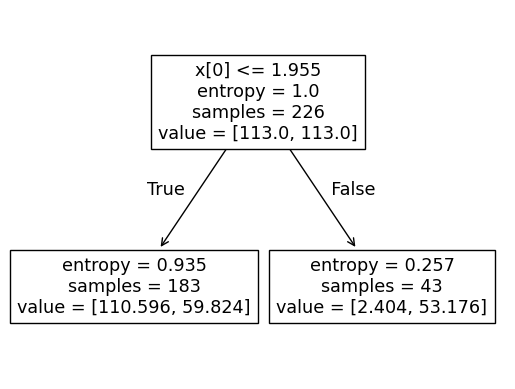

In [ ]:
from tf_chpvk_pv.modeling.train import *

train_df, test_df, tolerance_factor_dict = evaluate_t_sisso('')

tfs = ['t', 'tau', 't_jess']
tf_tresh = [2, 1, 2]
df_acc =pd.DataFrame()
clfs = {}

for tf, tresh in zip(tfs, tf_tresh):
    df_acc, clf_t = test_tolerance_factor(tf, train_df, test_df, tolerance_factor_dict, df_acc, n_tresh=tresh)
    clfs[tf] = clf_t

for feat in files:
    try:
        idx = int(feat.split('/')[-1].split('.csv')[0].split('_')[-1])
        tf = 't_sisso_' + str(idx)
        df = pd.read_csv(feat)
        t_sisso_expression = train_tree_sis_features(feat)
        train_df, test_df, tolerance_factor_dict = evaluate_t_sisso(t_sisso_expression, idx)
        df_acc, clf_t = test_tolerance_factor(tf, train_df, test_df, tolerance_factor_dict, df_acc, n_tresh=1)
        clfs[tf] = clf_t
    except:
        print('Error in %s' % feat)
        continue

In [27]:
df_acc.to_csv('/home/nomad-lanasc/Documents/Diego Garzon/TF-ChPVK-PV/models/results/tolerance factors accuracy for several operations.csv')

In [37]:
import os
missing_features = []

for feat in files:
    idx = int(feat.split('/')[-1].split('.csv')[0].split('_')[-1])
    tree_path = '/home/nomad-lanasc/Documents/Diego Garzon/TF-ChPVK-PV/models/trees/tree_t_sisso_' + str(idx) + '.png'
    ops_path = '/home/nomad-lanasc/Documents/Diego Garzon/TF-ChPVK-PV/data/features_space/features/ops/ops_' + str(idx) + '.txt'

    if os.path.exists(tree_path):
        continue
    else:
        missing_features.append(feat)

    with open(ops_path, 'r') as f:
        ops = f.readlines()
        if 'abs_diff' in ops[0]:
            continue
        else:
            print(idx, ops)

261 ["['mult', 'div', 'exp', 'sq']"]
260 ["['mult', 'div', 'exp', 'inv']"]
262 ["['mult', 'div', 'exp', 'cb']"]
264 ["['mult', 'div', 'exp', 'log']"]
263 ["['mult', 'div', 'exp', 'sqrt']"]


In [ ]:
#TODO check mistakes in the operations, to have a complete view of everything
#TODO analyze the t_sisso accuracy for all the combinations of operations
idx = 261
feat = '/home/nomad-lanasc/Documents/Diego Garzon/TF-ChPVK-PV/data/features_space/features/features/features_sisso_' + str(idx) + '.csv'
tf = 't_sisso_' + str(idx)
df = pd.read_csv(feat)
t_sisso_expression = train_tree_sis_features(feat)
train_df, test_df, tolerance_factor_dict = evaluate_t_sisso(t_sisso_expression, idx)
df_acc, clf_t = test_tolerance_factor(tf, train_df, test_df, tolerance_factor_dict, df_acc, n_tresh=1)
clfs[tf] = clf_t

2025-03-06 16:23:27.827 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features:81 - Training tree model with SISSO features...


/home/nomad-lanasc/.pyenv/lib/python3.11/site-packages/sklearn/utils/_array_api.py:745: RuntimeWarning: overflow encountered in cast
  array = numpy.asarray(array, order=order, dtype=dtype)
/home/nomad-lanasc/.pyenv/lib/python3.11/site-packages/sklearn/utils/_array_api.py:745: RuntimeWarning: overflow encountered in cast
  array = numpy.asarray(array, order=order, dtype=dtype)
/home/nomad-lanasc/.pyenv/lib/python3.11/site-packages/sklearn/utils/_array_api.py:745: RuntimeWarning: overflow encountered in cast
  array = numpy.asarray(array, order=order, dtype=dtype)
/home/nomad-lanasc/.pyenv/lib/python3.11/site-packages/sklearn/utils/_array_api.py:745: RuntimeWarning: overflow encountered in cast
  array = numpy.asarray(array, order=order, dtype=dtype)
/home/nomad-lanasc/.pyenv/lib/python3.11/site-packages/sklearn/utils/_array_api.py:745: RuntimeWarning: overflow encountered in cast
  array = numpy.asarray(array, order=order, dtype=dtype)


ValueError: 
All the 5 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/home/nomad-lanasc/.pyenv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/nomad-lanasc/.pyenv/lib/python3.11/site-packages/sklearn/base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/nomad-lanasc/.pyenv/lib/python3.11/site-packages/sklearn/tree/_classes.py", line 1009, in fit
    super()._fit(
  File "/home/nomad-lanasc/.pyenv/lib/python3.11/site-packages/sklearn/tree/_classes.py", line 257, in _fit
    self._compute_missing_values_in_feature_mask(X)
  File "/home/nomad-lanasc/.pyenv/lib/python3.11/site-packages/sklearn/tree/_classes.py", line 222, in _compute_missing_values_in_feature_mask
    _assert_all_finite_element_wise(X, xp=np, allow_nan=True, **common_kwargs)
  File "/home/nomad-lanasc/.pyenv/lib/python3.11/site-packages/sklearn/utils/validation.py", line 172, in _assert_all_finite_element_wise
    raise ValueError(msg_err)
ValueError: Input X contains infinity or a value too large for dtype('float32').


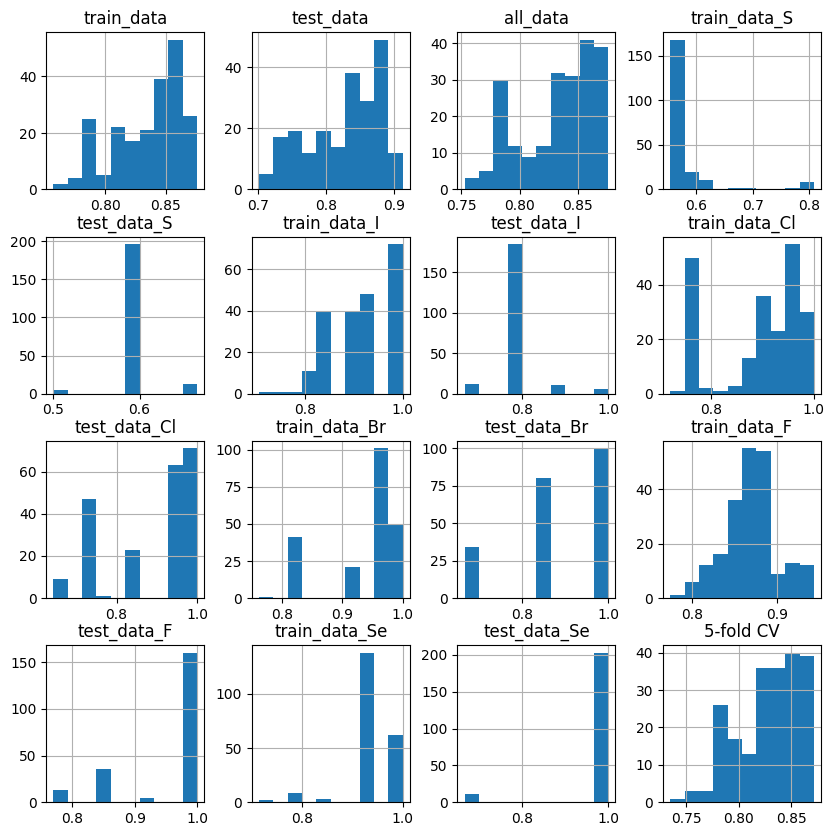

In [41]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv('/home/nomad-lanasc/Documents/Diego Garzon/TF-ChPVK-PV/models/results/tolerance factors accuracy for several operations.csv')
df.set_index('Unnamed: 0', inplace=True)


axs = df[[x for x in df.columns if 't_sisso' in x]].T.hist(figsize=(10, 10))
plt.show()

In [42]:
df[[x for x in df.columns if 't_sisso' in x]].max(axis=1)

Unnamed: 0
train_data       0.876106
test_data        0.912281
all_data         0.876325
train_data_S     0.808511
test_data_S      0.666667
train_data_I     1.000000
test_data_I      1.000000
train_data_Cl    1.000000
test_data_Cl     1.000000
train_data_Br    1.000000
test_data_Br     1.000000
train_data_F     0.943396
test_data_F      1.000000
train_data_Se    1.000000
test_data_Se     1.000000
5-fold CV        0.871401
dtype: float64

In [43]:
df.T.sort_values('test_data', ascending=False).head(10)

Unnamed: 0,train_data,test_data,all_data,train_data_S,test_data_S,train_data_I,test_data_I,train_data_Cl,test_data_Cl,train_data_Br,test_data_Br,train_data_F,test_data_F,train_data_Se,test_data_Se,5-fold CV
t_sisso_57,0.853982,0.912281,0.865724,0.574468,0.666667,0.882353,1.000000,0.964912,0.928571,1.000000,1.0,0.886792,1.0,0.928571,1.0,0.853623
t_sisso_56,0.853982,0.912281,0.865724,0.574468,0.666667,0.882353,1.000000,0.964912,0.928571,1.000000,1.0,0.886792,1.0,0.928571,1.0,0.853623
t_sisso_55,0.853982,0.912281,0.865724,0.574468,0.666667,0.882353,1.000000,0.964912,0.928571,1.000000,1.0,0.886792,1.0,0.928571,1.0,0.853623
t_sisso_127,0.858407,0.912281,0.869258,0.574468,0.583333,0.970588,1.000000,0.947368,1.000000,0.952381,1.0,0.886792,1.0,0.928571,1.0,0.858068
t_sisso_49,0.853982,0.912281,0.865724,0.574468,0.666667,0.882353,1.000000,0.964912,0.928571,1.000000,1.0,0.886792,1.0,0.928571,1.0,0.853623
t_sisso_124,0.853982,0.894737,0.862191,0.574468,0.583333,1.000000,0.888889,0.964912,1.000000,0.952381,1.0,0.830189,1.0,0.928571,1.0,0.853720
t_sisso_6,0.853982,0.894737,0.862191,0.595745,0.666667,0.852941,0.888889,0.964912,0.928571,1.000000,1.0,0.886792,1.0,0.928571,1.0,0.853720
t_sisso_64,0.853982,0.894737,0.862191,0.553191,0.583333,0.852941,0.888889,0.982456,1.000000,1.000000,1.0,0.905660,1.0,0.928571,1.0,0.849565
t_sisso_182,0.862832,0.894737,0.869258,0.574468,0.583333,0.970588,0.888889,0.947368,1.000000,0.952381,1.0,0.905660,1.0,0.928571,1.0,0.862512
t_sisso_125,0.858407,0.894737,0.865724,0.574468,0.583333,0.970588,0.888889,0.947368,1.000000,1.000000,1.0,0.867925,1.0,0.928571,1.0,0.858068


Set of operations = ['add', 'abs_diff', 'inv', 'log']

Identified expression for t_sisso: ((|(1.0 / rB_rX_ratio) - (1.0 / log_rA_rB_ratio)|) + ((1.0 / rB_rX_ratio) + (1.0 / log_rA_rB_ratio)))

Classification tree accuracy (for t_sisso_57) on the train set: 0.853982.

Classification tree accuracy (for t_sisso_57) on the train set (5 fold CV): 0.853623.

Classification tree accuracy (for t_sisso_57) on the test set: 0.912281.

t_sisso_57 < 4.377569 indicates stable perovskites.


Set of operations = ['add', 'abs_diff', 'inv', 'sqrt']

Identified expression for t_sisso: ((|(1.0 / rB_rX_ratio) - (1.0 / log_rA_rB_ratio)|) + ((1.0 / rB_rX_ratio) + (1.0 / log_rA_rB_ratio)))

Classification tree accuracy (for t_sisso_56) on the train set: 0.853982.

Classification tree accuracy (for t_sisso_56) on the train set (5 fold CV): 0.853623.

Classification tree accuracy (for t_sisso_56) on the test set: 0.912281.

t_sisso_56 < 4.377569 indicates stable perovskites.

Set of operations = ['add', 'abs_diff', 'inv', 'cb']

Identified expression for t_sisso: ((|(1.0 / rB_rX_ratio) - (1.0 / log_rA_rB_ratio)|) + ((1.0 / rB_rX_ratio) + (1.0 / log_rA_rB_ratio)))

Classification tree accuracy (for t_sisso_55) on the train set: 0.853982.

Classification tree accuracy (for t_sisso_55) on the train set (5 fold CV): 0.853623.

Classification tree accuracy (for t_sisso_55) on the test set: 0.912281.

t_sisso_55 < 4.377569 indicates stable perovskites.


Set of operations = ['sub', 'abs_diff', 'div', 'exp']

Identified expression for t_sisso: (((|rA_rX_ratio - log_rA_rB_ratio|) - (rB_rX_ratio / log_rA_rB_ratio)) - exp((log_rA_rB_ratio / rA_rX_ratio)))

Classification tree accuracy (for t_sisso_127) on the train set: 0.858407.

Classification tree accuracy (for t_sisso_127) on the train set (5 fold CV): 0.858068.

Classification tree accuracy (for t_sisso_127) on the test set: 0.912281.

t_sisso_127 < -2.573866 indicates stable perovskites.


Set of operations = ['add', 'abs_diff', 'exp', 'inv']

Identified expression for t_sisso: ((|(1.0 / rB_rX_ratio) - (1.0 / log_rA_rB_ratio)|) + ((1.0 / rB_rX_ratio) + (1.0 / log_rA_rB_ratio)))

Classification tree accuracy (for t_sisso_49) on the train set: 0.853982.

Classification tree accuracy (for t_sisso_49) on the train set (5 fold CV): 0.853623.

Classification tree accuracy (for t_sisso_49) on the test set: 0.912281.

t_sisso_49 < 4.377569 indicates stable perovskites.


In [5]:
import pickle

tolerance_factor_dict = {'t_sisso_57':['((|(1.0 / rB_rX_ratio) - (1.0 / log_rA_rB_ratio)|) + ((1.0 / rB_rX_ratio) + (1.0 / log_rA_rB_ratio)))'],
                         't_sisso_127':['(((|rA_rX_ratio - log_rA_rB_ratio|) - (rB_rX_ratio / log_rA_rB_ratio)) - exp((log_rA_rB_ratio / rA_rX_ratio)))']}

tolerance_factor_dict['t_sisso_57'].append(4.377569)
tolerance_factor_dict['t_sisso_127'].append(-2.573866)

with open('/home/nomad-lanasc/Documents/Diego Garzon/TF-ChPVK-PV/data/interim/tolerance_factors_ops.pkl', 'wb') as file:
    pickle.dump(tolerance_factor_dict, file)

In [6]:
tolerance_factor_dict

{'t_sisso_57': ['((|(1.0 / rB_rX_ratio) - (1.0 / log_rA_rB_ratio)|) + ((1.0 / rB_rX_ratio) + (1.0 / log_rA_rB_ratio)))',
  4.377569],
 't_sisso_127': ['(((|rA_rX_ratio - log_rA_rB_ratio|) - (rB_rX_ratio / log_rA_rB_ratio)) - exp((log_rA_rB_ratio / rA_rX_ratio)))',
  -2.573866]}

In [1]:
from tf_chpvk_pv.dataset import generate_compositions
from tf_chpvk_pv.modeling.predict import check_stable_compositions

new_tolerance_dict_path = '/home/nomad-lanasc/Documents/Diego Garzon/TF-ChPVK-PV/data/interim/tolerance_factors_ops.pkl'

element_selection_A = ["Ba", "Eu", "Pb", "Sr", "Ca", "Sn", "Cd", "Cu", "Mg",
                      "Zn", "Ge", "La", "Pr", "Ce", "Nd", "Yb", "Gd", "Sm", "Y",
                      "Dy", "Ho", "Er", "Tm", "Lu", "Sc", "Tl", "Bi"]

elements_selection_B = ["Si", "Ge", "V", "Rh", "Ti", "Ru", "Mo", "Ta", "Nb", "Hf",
                        "Zr", "Tb", "Pt", "Ce", "U", "Pd", "Ni", "Co", "Ga", "Al",
                        "Fe", "Cr", "In", "Mn", "Sc", "Lu", "Tm", "Er", "Ho", "Y",
                        "Yb"]


elements_selection = element_selection_A + elements_selection_B

df_generated_comp = generate_compositions(elements_selection, dict_tol_factors_path=new_tolerance_dict_path).dropna()

2025-03-11 16:24:51.889 | INFO     | tf_chpvk_pv.config:<module>:11 - PROJ_ROOT path is: /home/nomad-lanasc/Documents/Diego Garzon/TF-ChPVK-PV


2025-03-11 16:24:52.443 | INFO     | tf_chpvk_pv.dataset:generate_compositions:246 - Generating valid compositions...
2025-03-11 16:25:01.349 | SUCCESS  | tf_chpvk_pv.dataset:generate_compositions:405 - 1194 valid compositions generated.


According to t_sisso, 44 (3.6850921273031827%) compositions are predicted to be stable as perovskites:
['BaPrS3', 'BaCeS3', 'BaUS3', 'EuUS3', 'PbPrS3', 'PbCeS3', 'PbUS3', 'SrPrS3', 'SrCeS3', 'SrUS3', 'CuLaS3', 'CuLaSe3', 'MgUS3', 'LaLuS3', 'RhCeS3', 'RhCeSe3', 'BiYbS3', 'RhYbS3', 'GaYbS3', 'FeYbS3', 'ScYS3', 'RhYS3', 'GaYS3', 'FeYS3', 'ScHoS3', 'RhHoS3', 'GaHoS3', 'FeHoS3', 'ScErS3', 'RhErS3', 'GaErS3', 'FeErS3', 'ScTmS3', 'RhTmS3', 'GaTmS3', 'FeTmS3', 'BiLuS3', 'RhLuS3', 'GaLuS3', 'FeLuS3', 'RhTbS3', 'RhTbSe3', 'RhUS3', 'RhUSe3']


/home/nomad-lanasc/Documents/Diego Garzon/TF-ChPVK-PV/tf_chpvk_pv/plots.py:165: UserWarning: default value of fill_value changed from zero to None.
  element_counts = count_elements([x.replace('3', '') for x in stable_candidates_t_sisso])
/home/nomad-lanasc/.pyenv/lib/python3.11/site-packages/pymatviz/ptable/_process_data.py:117: UserWarning: NaN found in data
  self.check_and_replace_missing(strategy=missing_strategy)


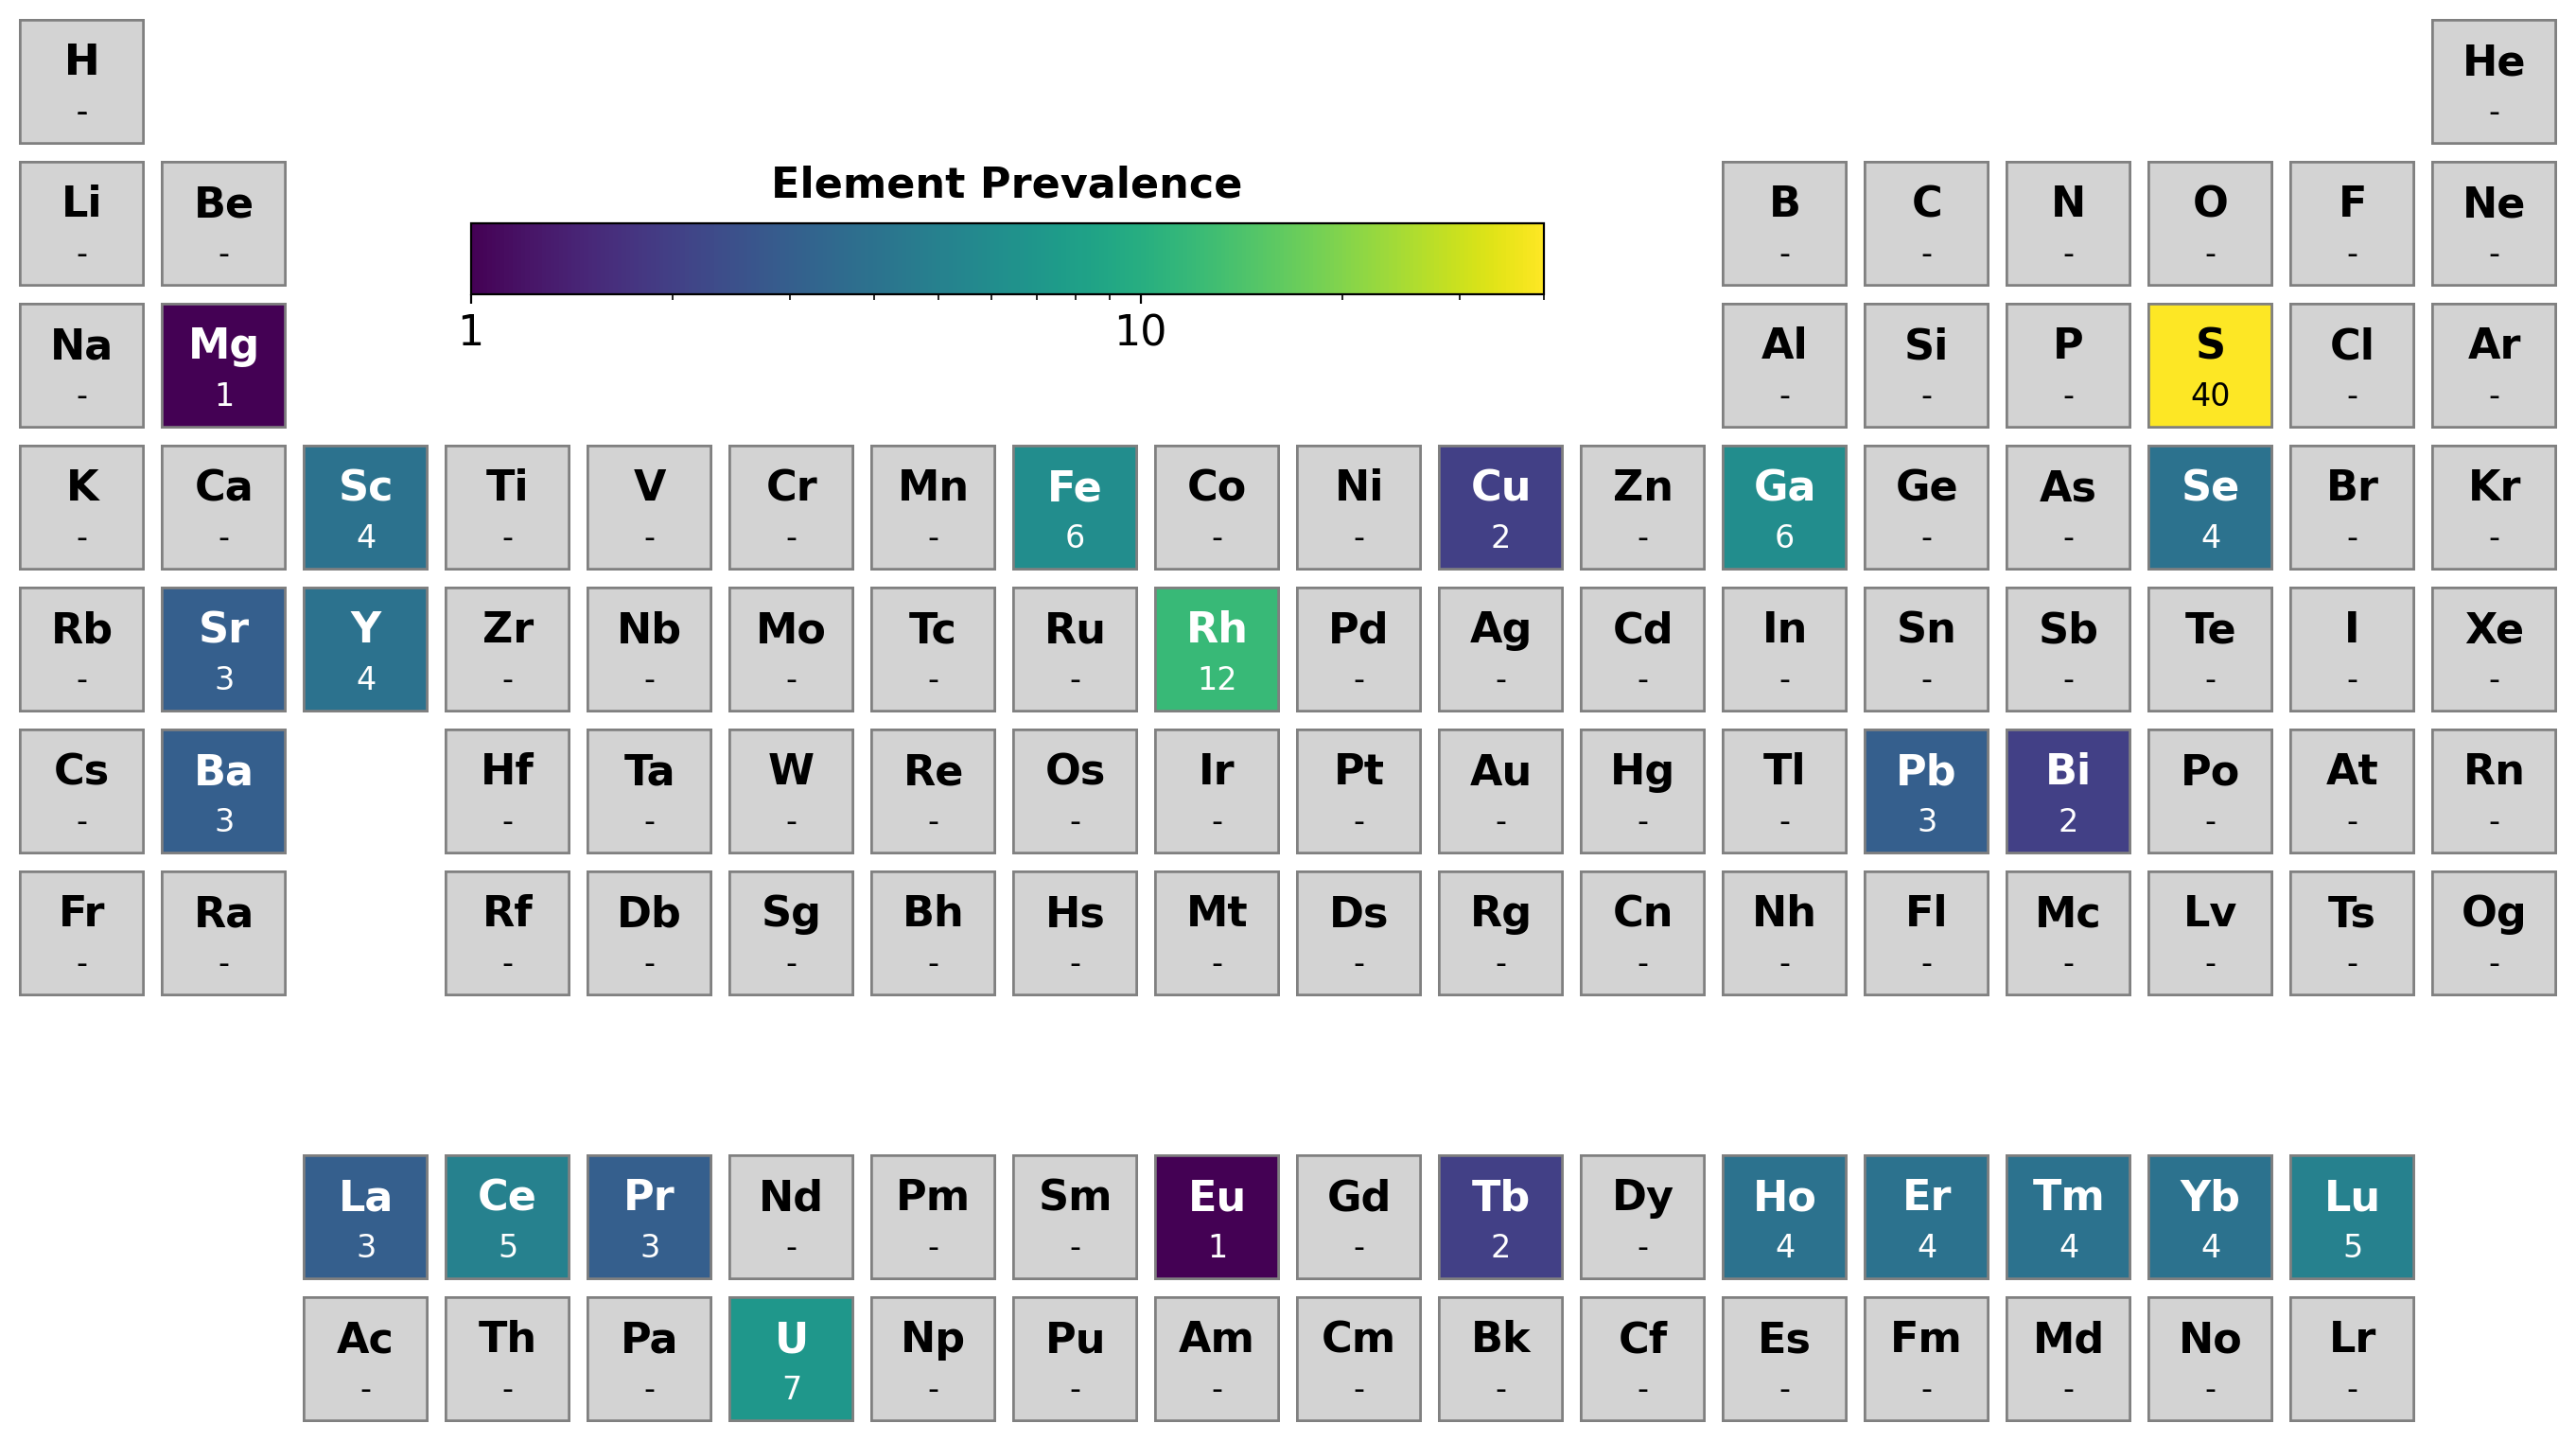

In [3]:
from tf_chpvk_pv.plots import graph_periodic_table

stable_candidates_t_sisso, df_out = check_stable_compositions('t_sisso_57', tolerance_factor_dict_path=new_tolerance_dict_path)

graph_periodic_table(stable_candidates_t_sisso)

According to t_sisso, 1128 (94.47236180904522%) compositions are predicted to be stable as perovskites:
['BaPbS3', 'BaPbSe3', 'BaSnS3', 'BaSnSe3', 'BaGeS3', 'BaGeSe3', 'BaPrSe3', 'BaCeSe3', 'BaSiS3', 'BaSiSe3', 'BaVS3', 'BaVSe3', 'BaRhS3', 'BaRhSe3', 'BaTiS3', 'BaTiSe3', 'BaRuS3', 'BaRuSe3', 'BaMoS3', 'BaMoSe3', 'BaTaS3', 'BaTaSe3', 'BaNbS3', 'BaNbSe3', 'BaHfS3', 'BaHfSe3', 'BaZrS3', 'BaZrSe3', 'BaTbS3', 'BaTbSe3', 'BaPtS3', 'BaPtSe3', 'BaUSe3', 'BaPdS3', 'BaPdSe3', 'BaNiS3', 'BaNiSe3', 'BaCoS3', 'BaCoSe3', 'BaCrS3', 'BaCrSe3', 'BaMnS3', 'BaMnSe3', 'EuPbS3', 'EuPbSe3', 'EuSnS3', 'EuSnSe3', 'EuCuS3', 'EuCuSe3', 'EuGeS3', 'EuGeSe3', 'EuLaS3', 'EuLaSe3', 'EuPrS3', 'EuPrSe3', 'EuCeS3', 'EuCeSe3', 'EuNdS3', 'EuNdSe3', 'EuYbS3', 'EuYbSe3', 'EuGdS3', 'EuGdSe3', 'EuSmS3', 'EuSmSe3', 'EuYS3', 'EuYSe3', 'EuDyS3', 'EuDySe3', 'EuHoS3', 'EuHoSe3', 'EuErS3', 'EuErSe3', 'EuTmS3', 'EuTmSe3', 'EuLuS3', 'EuLuSe3', 'EuScS3', 'EuScSe3', 'EuTlS3', 'EuTlSe3', 'EuBiS3', 'EuBiSe3', 'EuSiS3', 'EuSiSe3', 'EuVS3

/home/nomad-lanasc/Documents/Diego Garzon/TF-ChPVK-PV/tf_chpvk_pv/plots.py:165: UserWarning: default value of fill_value changed from zero to None.
  element_counts = count_elements([x.replace('3', '') for x in stable_candidates_t_sisso])
/home/nomad-lanasc/.pyenv/lib/python3.11/site-packages/pymatviz/ptable/_process_data.py:117: UserWarning: NaN found in data
  self.check_and_replace_missing(strategy=missing_strategy)


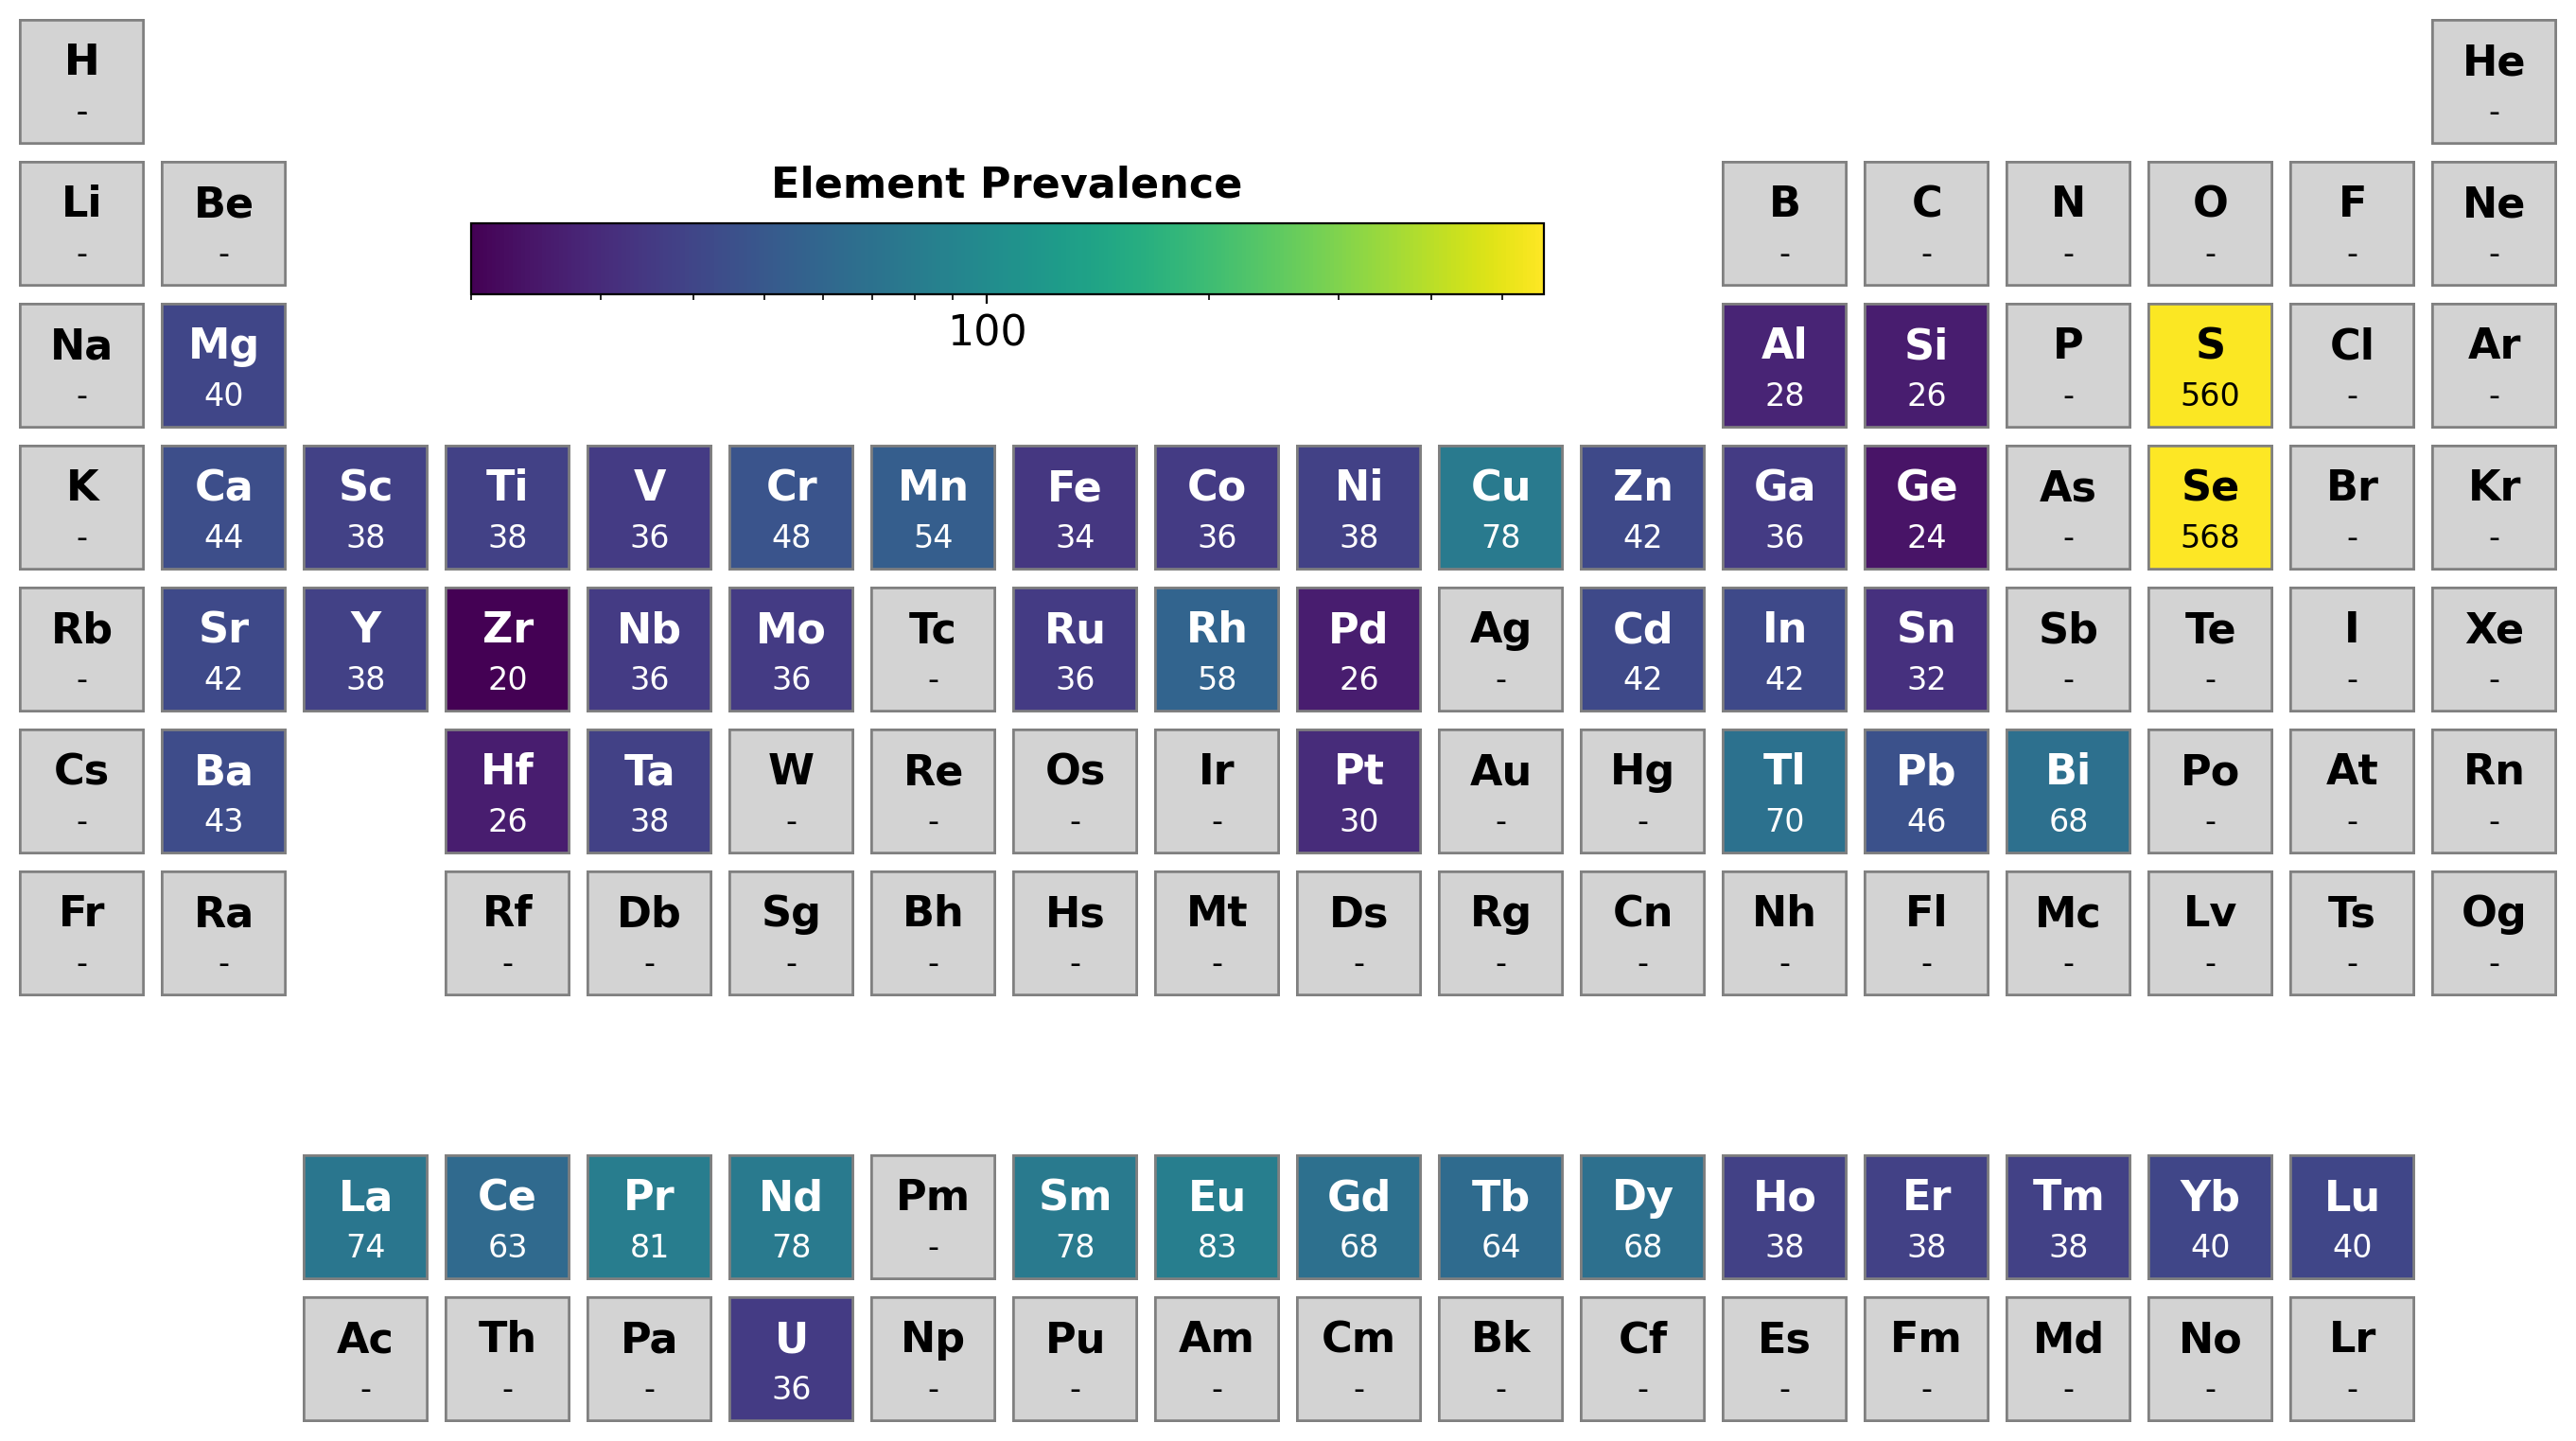

In [7]:
from tf_chpvk_pv.plots import graph_periodic_table

stable_candidates_t_sisso, df_out = check_stable_compositions('t_sisso_127', tolerance_factor_dict_path=new_tolerance_dict_path)

graph_periodic_table(stable_candidates_t_sisso)